<a href="https://colab.research.google.com/github/kodai-utsunomiya-mdl/spurious_exp/blob/main/sp_exp_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install wilds

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.2/126.2 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.8/78.8 kB 7.7 MB/s eta 0:00:00


In [2]:
!pip install pot

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 901.7/901.7 kB 24.0 MB/s eta 0:00:00


In [3]:
import matplotlib.pyplot as plt
plt.rc("figure", dpi=100, facecolor=(1, 1, 1))
plt.rc("font", family='stixgeneral', size=13)
plt.rc("axes", facecolor='white', titlesize=16)
plt.rc("mathtext", fontset='cm')
plt.rc('text', usetex=False)

# WaterBirds

Using device: cuda
Selected Dataset: WaterBirds
Initialization: muP
Skip Connections: DISABLED
Analysis will be performed on: 'both' dataset(s)
Mutual information analysis is DISABLED.
t-SNE visualization is DISABLED.
Logit layer analysis is DISABLED.
Layers to be analyzed: ['layer_1']

Preparing WaterBirds dataset...
You can also download the dataset manually at https://wilds.stanford.edu/downloads.


489291776Byte [00:14, 33358284.44Byte/s]


Extracting data/waterbirds_v1.0/archive.tar.gz to data/waterbirds_v1.0

It took 0.36 minutes to download and uncompress the dataset.

Showing original images before normalization...

Displaying 10 sample images from the WaterBirds train set...


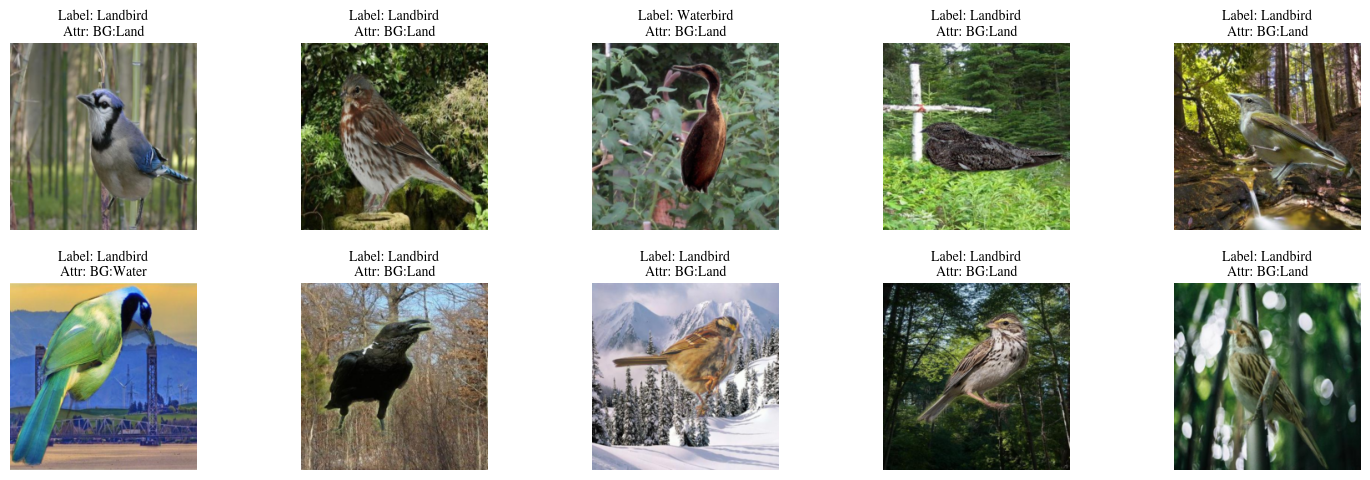


Applying L2 normalization to input data (||x||_2 = 1)...
Using 4795 samples for training and 2000 samples for testing.

--- Train Set Group Distribution ---
Waterbird on Water (y=+1, a=+1)    :  1057 samples
Waterbird on Land (y=+1, a=-1)     :    56 samples
Landbird on Water (y=-1, a=+1)     :   184 samples
Landbird on Land (y=-1, a=-1)      :  3498 samples
Total                              :  4795 samples


--- Test Set Group Distribution ---
Waterbird on Water (y=+1, a=+1)    :   196 samples
Waterbird on Land (y=+1, a=-1)     :   212 samples
Landbird on Water (y=-1, a=+1)     :   768 samples
Landbird on Land (y=-1, a=-1)      :   824 samples
Total                              :  2000 samples


Setting up MLP model and optimizer...

Applying manual parametrization for 'muP'...
   - Input Dim (d): 150528, Hidden Dim (n): 2048, Base LR (η): 0.1
   - Input Layer (W^1):       Init Var = 2.00, LR = 2.05e+02
   - Output Layer (W^L+1): Init Var = 1/4194304, LR = 4.88e-05

Starting trainin

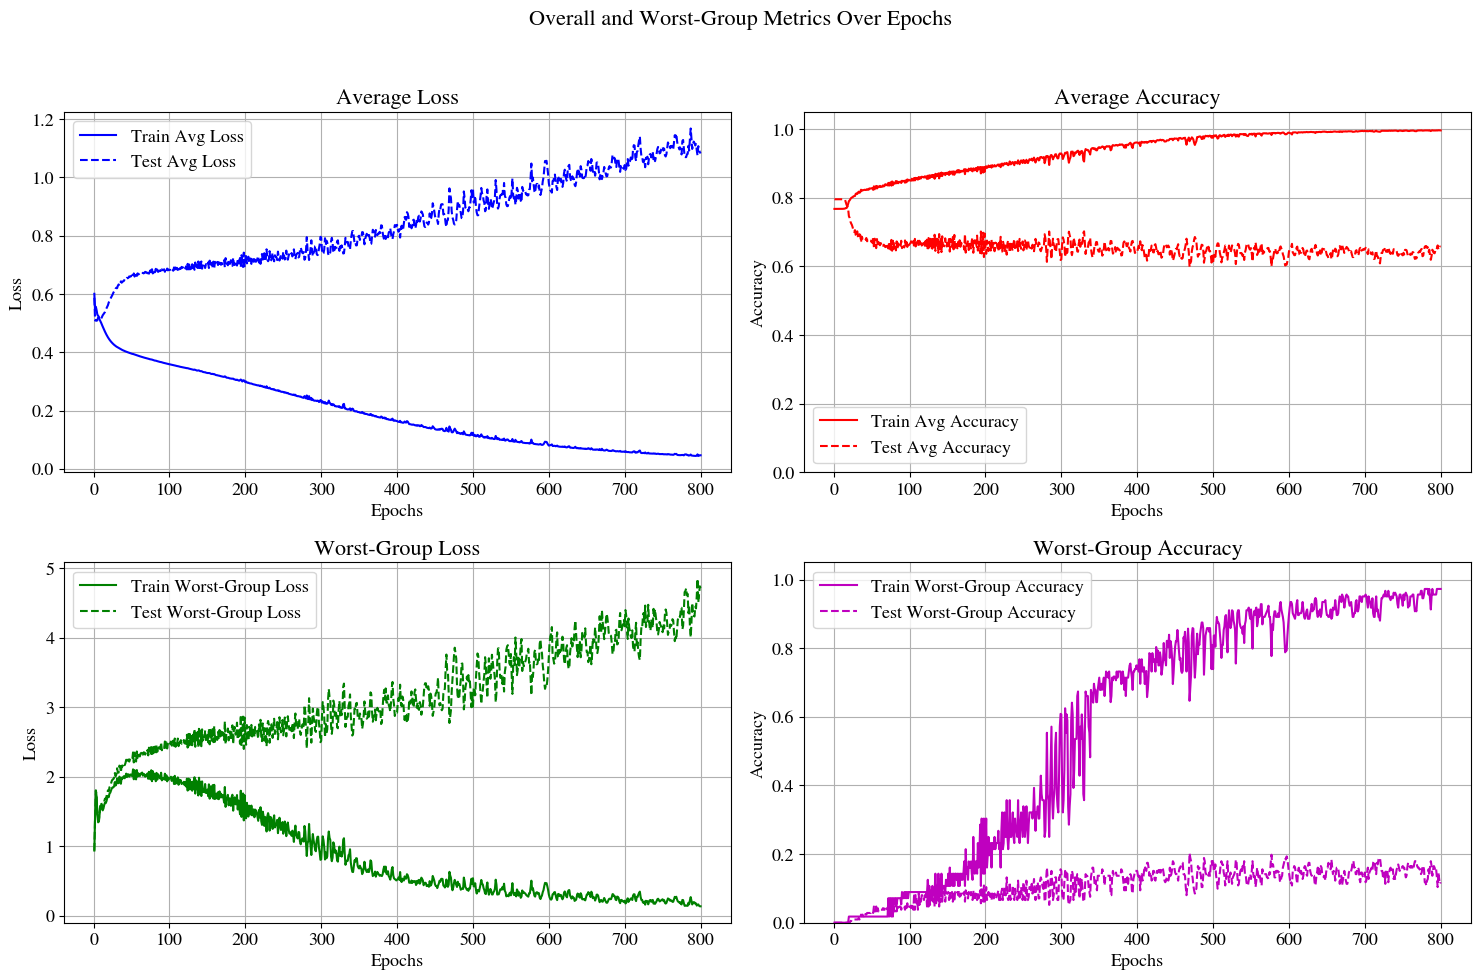

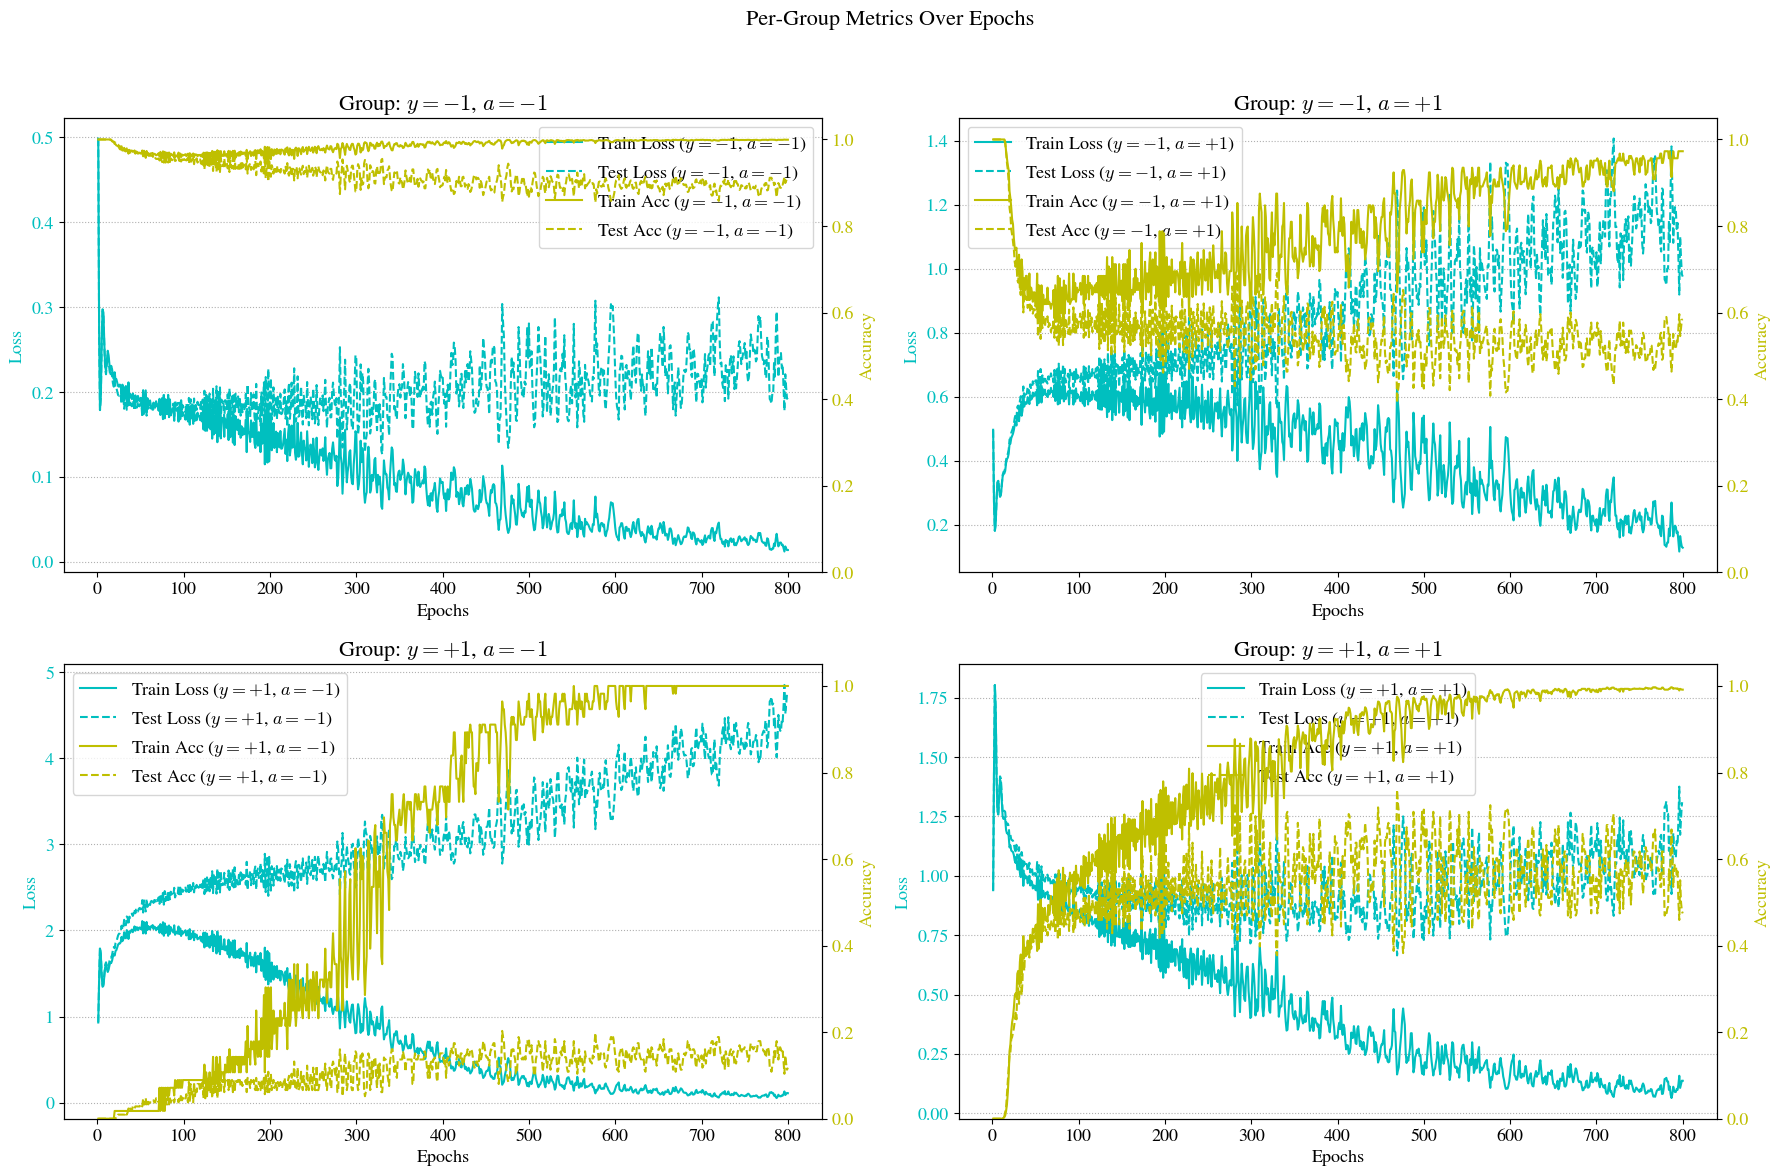


Plotting misclassification rates for each group on the test set...


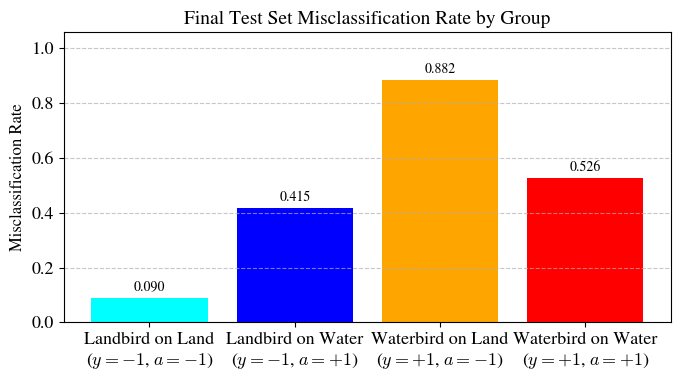


Plotting the evolution of Wasserstein distances over epochs (Train vs. Test)...


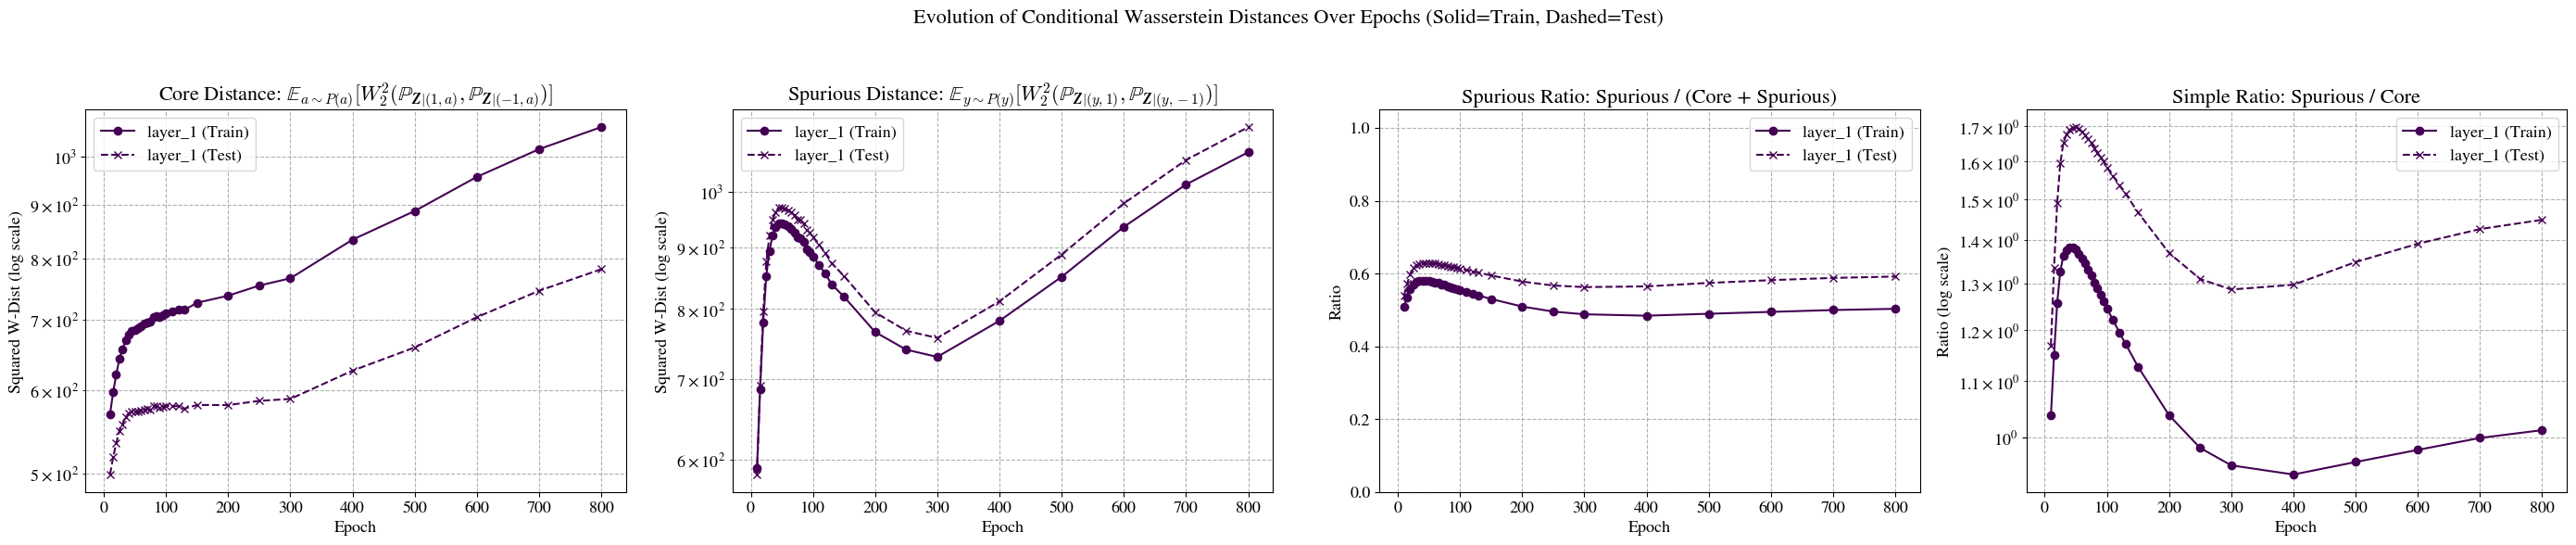

In [6]:
import numpy as np
import pandas as pd
import time
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, Subset
from torchvision.datasets import MNIST
from torchvision import transforms
import matplotlib.pyplot as plt
import os
from sklearn.manifold import TSNE

# 'wilds'ライブラリのインポート
try:
    import wilds
except ImportError:
    print("Warning: 'wilds' library not found. WaterBirds dataset will not be available.")
    print("Please install it using: pip install wilds")
    wilds = None

# 'pot'ライブラリのインポート
try:
    import ot
except ImportError:
    print("Warning: 'pot' library not found. Wasserstein distance analysis will not be available.")
    print("Please install it using: pip install pot")
    ot = None

# ==============================================================================
# ベクトル全体の相互情報量を計算する関数
# ==============================================================================
from scipy.special import digamma
from sklearn.neighbors import NearestNeighbors

def vector_mutual_information(X: np.ndarray, y: np.ndarray, n_neighbors: int = 5) -> float:
    """ Kozachenko-Leonenko推定法を用いてベクトルXとラベルyの相互情報量を計算する """
    n_samples = X.shape[0]
    unique_classes, y_indices, class_counts = np.unique(y, return_inverse=True, return_counts=True)

    radii = np.zeros(n_samples)
    # 各クラス内でk最近傍までの距離（半径）を計算
    for i, c in enumerate(unique_classes):
        class_indices = np.where(y_indices == i)[0]
        X_class = X[class_indices]
        if len(X_class) <= n_neighbors: continue

        nn = NearestNeighbors(n_neighbors=n_neighbors + 1, metric='chebyshev', algorithm='ball_tree')
        nn.fit(X_class)
        class_radii, _ = nn.kneighbors(X_class, n_neighbors=n_neighbors + 1)
        radii[class_indices] = class_radii[:, n_neighbors]

    radii[radii == 0] = 1e-15  # 半径が0にならないようにする

    # 全データで，各点の半径内にいくつの他の点が含まれるかを数える
    nn_full = NearestNeighbors(metric='chebyshev', algorithm='ball_tree')
    nn_full.fit(X)
    m_i_counts = nn_full.radius_neighbors(X, radius=radii, return_distance=False)
    m_i = np.array([len(neighbors) for neighbors in m_i_counts])

    # 相互情報量を計算
    mi_val = digamma(n_samples) + digamma(n_neighbors) - np.mean(digamma(class_counts[y_indices])) - np.mean(digamma(m_i))

    return max(0, mi_val)

# ==============================================================================
# 条件付き相互情報量を計算するヘルパー関数
# ==============================================================================
def conditional_mutual_information(Z: np.ndarray, target: np.ndarray, condition: np.ndarray,
                                     n_neighbors: int = 5) -> float:
    """ 条件変数でデータを分割し，各部分集合の相互情報量の加重平均を計算する """
    total_cmi = 0.0
    unique_conditions = np.unique(condition)
    for c_val in unique_conditions:
        p_condition = np.mean(condition == c_val)
        indices = (condition == c_val)
        Z_sub, target_sub = Z[indices], target[indices]

        if len(Z_sub) < n_neighbors * 2: continue # サンプルが少なすぎる場合はスキップ

        mi_sub = vector_mutual_information(Z_sub, target_sub, n_neighbors=n_neighbors)
        if not np.isnan(mi_sub):
            total_cmi += p_condition * mi_sub

    return total_cmi

# ==============================================================================
# 条件付きWasserstein距離を計算するヘルパー関数
# ==============================================================================
def conditional_wasserstein_distance(Z: np.ndarray, primary_var: np.ndarray, condition_var: np.ndarray) -> float:
    """
    条件変数でデータを分割し，各部分集合における主変数間のWasserstein距離の加重平均を計算する．
    具体的には， E_c [ W_2^2( P(Z | primary=v1, condition=c), P(Z | primary=v2, condition=c) ) ] を計算する．
    """
    if ot is None:
        return np.nan

    total_wd = 0.0
    unique_conditions = np.unique(condition_var)

    for c_val in unique_conditions:
        p_condition = np.mean(condition_var == c_val)
        indices_c = (condition_var == c_val)

        Z_sub = Z[indices_c]
        primary_sub = primary_var[indices_c]

        unique_primary_vals = np.unique(primary_sub)
        if len(unique_primary_vals) < 2:
            continue

        # 主変数が2値(+1, -1)であることを仮定
        val1, val2 = unique_primary_vals[0], unique_primary_vals[1]

        indices_p1 = (primary_sub == val1)
        indices_p2 = (primary_sub == val2)

        Z1 = Z_sub[indices_p1]
        Z2 = Z_sub[indices_p2]

        if Z1.shape[0] == 0 or Z2.shape[0] == 0:
            continue

        # コスト行列を計算 (2乗ユークリッド距離)
        cost_matrix = ot.dist(Z1, Z2, metric='sqeuclidean')

        # 各サンプルの重み (一様分布)
        n1, n2 = Z1.shape[0], Z2.shape[0]
        a_weights = np.ones((n1,)) / n1
        b_weights = np.ones((n2,)) / n2

        # 2-Wasserstein距離の2乗 (EMD) を計算
        try:
            wasserstein_dist_sq = ot.emd2(a_weights, b_weights, cost_matrix)
            if not np.isnan(wasserstein_dist_sq):
                total_wd += p_condition * wasserstein_dist_sq
        except Exception as e:
            print(f"Warning: Wasserstein distance calculation failed for a subgroup. Error: {e}")

    return total_wd

# ==============================================================================
# データ生成/ロード関数
# ==============================================================================
def colorize_mnist(images, labels, correlation):
    """ MNISTデータセットに色付けを行い，ラベルと色の相関を持つデータを作成する """
    labels_pm1 = (labels >= 5).float() * 2.0 - 1.0
    images_gray = images.float() / 255.0
    n_samples = len(labels_pm1)

    images_rgb = torch.stack([images_gray, images_gray, images_gray], dim=1)

    prob_color_matches_label = (1.0 + correlation) / 2.0
    attributes_pm1 = torch.zeros_like(labels_pm1)

    for i in range(n_samples):
        y_i = labels_pm1[i]
        if torch.rand(1) < prob_color_matches_label:
            a_i = y_i
        else:
            a_i = -y_i
        attributes_pm1[i] = a_i

    digit_mask = (images_gray > 0.01).unsqueeze(1)
    color_factors = torch.ones(n_samples, 3, 1, 1, dtype=images_gray.dtype)

    red_indices = (attributes_pm1 == 1.0)
    green_indices = (attributes_pm1 == -1.0)

    color_factors[red_indices, 1, :, :] = 0.25
    color_factors[red_indices, 2, :, :] = 0.25
    color_factors[green_indices, 0, :, :] = 0.25
    color_factors[green_indices, 2, :, :] = 0.25

    colored_images = images_rgb * color_factors
    final_images_rgb = torch.where(digit_mask, colored_images, images_rgb)

    return final_images_rgb, labels_pm1, attributes_pm1

def get_waterbirds_dataset(num_train, num_test, image_size):
    """ WILDSライブラリからWaterBirdsデータセットをロードする """
    if wilds is None:
        raise ImportError("WaterBirds dataset requires the 'wilds' library. Please install it.")

    dataset_archive_path = 'data/waterbirds_v1.0/archive.tar.gz'
    if os.path.exists(dataset_archive_path):
        print(f"Removing potentially corrupted archive: {dataset_archive_path}")
        try:
            os.remove(dataset_archive_path)
        except OSError as e:
            print(f"Error removing archive file: {e}")

    full_dataset = wilds.get_dataset(dataset='waterbirds', root_dir='data', download=True)
    transform = transforms.Compose([transforms.Resize((image_size, image_size)), transforms.ToTensor()])

    train_dataset = full_dataset.get_subset('train', transform=transform)
    train_indices = np.random.choice(len(train_dataset), num_train, replace=False) if num_train < len(train_dataset) else np.arange(len(train_dataset))
    train_subset = Subset(train_dataset, train_indices)

    test_dataset = full_dataset.get_subset('test', transform=transform)
    test_indices = np.random.choice(len(test_dataset), num_test, replace=False) if num_test < len(test_dataset) else np.arange(len(test_dataset))
    test_subset = Subset(test_dataset, test_indices)

    train_loader = DataLoader(train_subset, batch_size=len(train_subset), shuffle=True)
    test_loader = DataLoader(test_subset, batch_size=len(test_subset), shuffle=False)

    X_train, y_train_01, metadata_train = next(iter(train_loader))
    X_test, y_test_01, metadata_test = next(iter(test_loader))

    y_train_pm1 = y_train_01.float() * 2.0 - 1.0
    a_train_pm1 = metadata_train[:, 0].float() * 2.0 - 1.0
    y_test_pm1 = y_test_01.float() * 2.0 - 1.0
    a_test_pm1 = metadata_test[:, 0].float() * 2.0 - 1.0

    return X_train, y_train_pm1, a_train_pm1, X_test, y_test_pm1, a_test_pm1

# ==============================================================================
#  ユーティリティ関数
# ==============================================================================
def l2_normalize_images(images_tensor):
    """ バッチ内の各画像をL2ノルムが1になるように正規化する """
    original_shape = images_tensor.shape
    # 画像をフラット化
    images_flat = images_tensor.view(original_shape[0], -1)
    # L2ノルムを計算して正規化
    norms = torch.linalg.norm(images_flat, ord=2, dim=1, keepdim=True)
    images_flat_normalized = images_flat / (norms + 1e-8) # ゼロ除算を防止
    # 元の形状に戻す
    images_normalized = images_flat_normalized.view(original_shape)
    return images_normalized

def show_dataset_samples(X_data, y_data, a_data, dataset_name, num_samples=10):
    """ データセットのサンプル画像を表示する """
    print(f"\nDisplaying {num_samples} sample images from the {dataset_name} train set...")
    plt.figure(figsize=(15, 5))
    for i in range(num_samples):
        image, label, attr = X_data[i], y_data[i].item(), a_data[i].item()
        image_to_show = image.permute(1, 2, 0).cpu().numpy()

        if dataset_name == 'ColoredMNIST':
            label_text, attr_text = ("Digit>=5" if label == 1.0 else "Digit<5"), ("Red" if attr == 1.0 else "Green")
        elif dataset_name == 'WaterBirds':
            label_text, attr_text = ("Waterbird" if label == 1.0 else "Landbird"), ("BG:Water" if attr == 1.0 else "BG:Land")
        else:
            label_text, attr_text = f"y={label}", f"a={attr}"

        plt.subplot(2, num_samples // 2, i + 1)
        plt.imshow(image_to_show)
        plt.title(f"Label: {label_text}\nAttr: {attr_text}", fontsize=10)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

def display_group_distribution(y_data, a_data, dataset_name):
    """ データセットのグループごとのサンプル数を表示する """
    print(f"\n--- {dataset_name} Group Distribution ---")
    group_counts = {
        'Waterbird on Water (y=+1, a=+1)': ((y_data == 1) & (a_data == 1)).sum().item(),
        'Waterbird on Land (y=+1, a=-1)': ((y_data == 1) & (a_data == -1)).sum().item(),
        'Landbird on Water (y=-1, a=+1)': ((y_data == -1) & (a_data == 1)).sum().item(),
        'Landbird on Land (y=-1, a=-1)': ((y_data == -1) & (a_data == -1)).sum().item()
    }
    for name, count in group_counts.items():
        print(f"{name:<35}: {count:>5} samples")
    print(f"{'Total':<35}: {len(y_data):>5} samples\n")

def visualize_tsne_layers(model, X_train, y_train, a_train, X_test, y_test, a_test, target_layers, batch_size, device, epoch_num=None):
    """
    学習後のモデルの各層とロジットの特徴表現をt-SNEで可視化する関数
    """
    title_suffix = f" (Epoch {epoch_num})" if epoch_num is not None else " (Final)"
    print(f"\nVisualizing feature representations using t-SNE{title_suffix}...")
    model.eval()

    # --- 全データの特徴量を取得 ---
    all_train_outputs_dict = {}
    all_test_outputs_dict = {}
    with torch.no_grad():
        train_loader_full = DataLoader(TensorDataset(X_train), batch_size=batch_size)
        for i, (X_batch,) in enumerate(train_loader_full):
            _, batch_outputs = model(X_batch.to(device))
            for key, value in batch_outputs.items():
                if key in target_layers: # 解析対象レイヤーのみ抽出
                    if i == 0:
                        all_train_outputs_dict[key] = value.cpu()
                    else:
                        all_train_outputs_dict[key] = torch.cat((all_train_outputs_dict[key], value.cpu()), dim=0)

        test_loader_full = DataLoader(TensorDataset(X_test), batch_size=batch_size)
        for i, (X_batch,) in enumerate(test_loader_full):
            _, batch_outputs = model(X_batch.to(device))
            for key, value in batch_outputs.items():
                if key in target_layers: # 解析対象レイヤーのみ抽出
                    if i == 0:
                        all_test_outputs_dict[key] = value.cpu()
                    else:
                        all_test_outputs_dict[key] = torch.cat((all_test_outputs_dict[key], value.cpu()), dim=0)

    # --- プロットの準備 ---
    num_plots = len(target_layers)
    fig, axes = plt.subplots(2, num_plots, figsize=(6 * num_plots, 10), squeeze=False)
    fig.suptitle(f't-SNE Visualization of Layer Representations{title_suffix}', fontsize=16)

    groups = {
        '$y = +1$, $a = +1$ (Tr-Maj)': {'y': 1, 'a': 1, 'color': 'red', 'marker': 'o'},
        '$y = +1$, $a = -1$ (Tr-Min)': {'y': 1, 'a': -1, 'color': 'orange', 'marker': 'x'},
        '$y = -1$, $a = +1$ (Tr-Min)': {'y': -1, 'a': 1, 'color': 'blue', 'marker': 'x'},
        '$y = -1$, $a = -1$ (Tr-Maj)': {'y': -1, 'a': -1, 'color': 'cyan', 'marker': 'o'}
    }

    # --- 各層をループして可視化 ---
    for i, layer_name in enumerate(target_layers):
        ax_train = axes[0, i]
        ax_test = axes[1, i]

        if layer_name not in all_train_outputs_dict or layer_name not in all_test_outputs_dict:
            print(f"Warning: {layer_name} not found in model outputs. Skipping.")
            ax_train.axis('off')
            ax_test.axis('off')
            continue

        # --- 訓練データ ---
        Z_train = all_train_outputs_dict[layer_name].numpy()
        if Z_train.ndim == 1: Z_train = Z_train.reshape(-1, 1)
        if Z_train.ndim > 2: Z_train = Z_train.reshape(Z_train.shape[0], -1)

        try:
            tsne = TSNE(n_components=2, perplexity=min(30, len(Z_train)-1), learning_rate='auto', init='pca', random_state=42)
            print(f"Running t-SNE for Train Data ({layer_name})...")
            Z_train_2d = tsne.fit_transform(Z_train)
        except Exception as e:
            print(f"t-SNE failed for Train Data ({layer_name}): {e}. Using random init.")
            tsne = TSNE(n_components=2, perplexity=min(30, len(Z_train)-1), learning_rate='auto', init='random', random_state=42)
            Z_train_2d = tsne.fit_transform(Z_train)

        for label, props in groups.items():
            mask = (y_train.numpy() == props['y']) & (a_train.numpy() == props['a'])
            ax_train.scatter(Z_train_2d[mask, 0], Z_train_2d[mask, 1],
                                         c=props['color'], marker=props['marker'], label=label, alpha=0.7, s=10)
        ax_train.set_title(f'Train Data - {layer_name}')
        ax_train.set_xticks([])
        ax_train.set_yticks([])

        # --- テストデータ ---
        Z_test = all_test_outputs_dict[layer_name].numpy()
        if Z_test.ndim == 1: Z_test = Z_test.reshape(-1, 1)
        if Z_test.ndim > 2: Z_test = Z_test.reshape(Z_test.shape[0], -1)

        try:
            tsne = TSNE(n_components=2, perplexity=min(30, len(Z_test)-1), learning_rate='auto', init='pca', random_state=42)
            print(f"Running t-SNE for Test Data ({layer_name})...")
            Z_test_2d = tsne.fit_transform(Z_test)
        except Exception as e:
            print(f"t-SNE failed for Test Data ({layer_name}): {e}. Using random init.")
            tsne = TSNE(n_components=2, perplexity=min(30, len(Z_test)-1), learning_rate='auto', init='random', random_state=42)
            Z_test_2d = tsne.fit_transform(Z_test)

        for label, props in groups.items():
            mask = (y_test.numpy() == props['y']) & (a_test.numpy() == props['a'])
            ax_test.scatter(Z_test_2d[mask, 0], Z_test_2d[mask, 1],
                                        c=props['color'], marker=props['marker'], label=label, alpha=0.7, s=10)
        ax_test.set_title(f'Test Data - {layer_name}')
        ax_test.set_xticks([])
        ax_test.set_yticks([])

    handles, labels = axes[0, 0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='lower center', ncol=4, bbox_to_anchor=(0.5, -0.01))

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# ==============================================================================
# 相互情報量の時系列変化をプロットする関数
# ==============================================================================
def plot_mi_evolution(mi_history_train, mi_history_test, all_target_layers):
    """
    学習過程における相互情報量の変化を時系列でプロットする関数
    """
    print("\nPlotting the evolution of mutual information over epochs (Train vs. Test)...")

    if not mi_history_train and not mi_history_test:
        print("No MI history to plot.")
        return

    epochs = sorted(mi_history_train.keys() if mi_history_train else mi_history_test.keys())

    # データ整形
    plot_data_train = {layer: {'core': [], 'spurious': [], 'ratio': []} for layer in all_target_layers}
    plot_data_test = {layer: {'core': [], 'spurious': [], 'ratio': []} for layer in all_target_layers}
    histories = {'train': (mi_history_train, plot_data_train), 'test': (mi_history_test, plot_data_test)}

    for mode, (history, plot_data) in histories.items():
        if not history: continue
        for epoch in epochs:
            for layer in all_target_layers:
                if layer in history.get(epoch, {}):
                    core, spurious, ratio = history[epoch][layer]
                    plot_data[layer]['core'].append(core)
                    plot_data[layer]['spurious'].append(spurious)
                    plot_data[layer]['ratio'].append(ratio)
                else:
                    plot_data[layer]['core'].append(np.nan)
                    plot_data[layer]['spurious'].append(np.nan)
                    plot_data[layer]['ratio'].append(np.nan)

    num_layers = len(all_target_layers)
    colors = plt.cm.viridis(np.linspace(0, 1, num_layers))

    fig, axes = plt.subplots(1, 3, figsize=(21, 6))
    fig.suptitle('Evolution of Information Quantities Over Epochs (Solid=Train, Dashed=Test)', fontsize=16)

    plot_configs = [
        {'ax': axes[0], 'key': 'core', 'title': 'Core Information: $I(Z; Y | A)$', 'ylabel': 'nats'},
        {'ax': axes[1], 'key': 'spurious', 'title': 'Spurious Information: $I(Z; A | Y)$', 'ylabel': 'nats'},
        {'ax': axes[2], 'key': 'ratio', 'title': 'Spurious Information Ratio', 'ylabel': 'Ratio'},
    ]

    for config in plot_configs:
        ax = config['ax']
        key = config['key']
        for i, layer in enumerate(all_target_layers):
            if mi_history_train:
                ax.plot(epochs, plot_data_train[layer][key], marker='o', linestyle='-', color=colors[i], label=f'{layer} (Train)')
            if mi_history_test:
                ax.plot(epochs, plot_data_test[layer][key], marker='x', linestyle='--', color=colors[i], label=f'{layer} (Test)')

        ax.set_title(config['title'])
        ax.set_xlabel('Epoch')
        ax.set_ylabel(config['ylabel'])
        if key == 'ratio': ax.set_ylim(0, 1.05)
        ax.legend()
        ax.grid(True)

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# ==============================================================================
# Wasserstein距離の時系列変化をプロットする関数
# ==============================================================================
def plot_wd_evolution(wd_history_train, wd_history_test, all_target_layers):
    """
    学習過程におけるWasserstein距離とその比率の変化を時系列でプロットする関数
    (Train: 実線, Test: 破線)
    """
    print("\nPlotting the evolution of Wasserstein distances over epochs (Train vs. Test)...")

    if ot is None or (not wd_history_train and not wd_history_test):
        print("No Wasserstein distance history to plot (or 'pot' library not found).")
        return

    epochs = sorted(wd_history_train.keys() if wd_history_train else wd_history_test.keys())

    # データを整形
    plot_data_train = {layer: {'core': [], 'spurious': [], 'ratio': [], 'simple_ratio': []} for layer in all_target_layers}
    plot_data_test = {layer: {'core': [], 'spurious': [], 'ratio': [], 'simple_ratio': []} for layer in all_target_layers}
    histories = {'train': (wd_history_train, plot_data_train), 'test': (wd_history_test, plot_data_test)}

    for mode, (history, plot_data) in histories.items():
        if not history: continue
        for epoch in epochs:
            for layer in all_target_layers:
                if layer in history.get(epoch, {}):
                    core, spurious, ratio, simple_ratio = history[epoch][layer]
                    plot_data[layer]['core'].append(core)
                    plot_data[layer]['spurious'].append(spurious)
                    plot_data[layer]['ratio'].append(ratio)
                    plot_data[layer]['simple_ratio'].append(simple_ratio)
                else:
                    plot_data[layer]['core'].append(np.nan)
                    plot_data[layer]['spurious'].append(np.nan)
                    plot_data[layer]['ratio'].append(np.nan)
                    plot_data[layer]['simple_ratio'].append(np.nan)

    num_layers = len(all_target_layers)
    colors = plt.cm.viridis(np.linspace(0, 1, num_layers))

    fig, axes = plt.subplots(1, 4, figsize=(28, 6))
    fig.suptitle('Evolution of Conditional Wasserstein Distances Over Epochs (Solid=Train, Dashed=Test)', fontsize=16)

    plot_configs = [
        {'ax': axes[0], 'key': 'core', 'title': 'Core Distance: $\\mathbb{E}_{a \\sim P(a)} [W_2^2(\\mathbb{P}_{\\boldsymbol{Z}|(1,a)}, \\mathbb{P}_{\\boldsymbol{Z}|(-1,a)})]$', 'log': True, 'ylabel': 'Squared W-Dist (log scale)'},
        {'ax': axes[1], 'key': 'spurious', 'title': 'Spurious Distance: $\\mathbb{E}_{y \\sim P(y)} [W_2^2(\\mathbb{P}_{\\boldsymbol{Z}|(y,1)}, \\mathbb{P}_{\\boldsymbol{Z}|(y,-1)})]$', 'log': True, 'ylabel': 'Squared W-Dist (log scale)'},
        {'ax': axes[2], 'key': 'ratio', 'title': 'Spurious Ratio: Spurious / (Core + Spurious)', 'log': False, 'ylabel': 'Ratio'},
        {'ax': axes[3], 'key': 'simple_ratio', 'title': 'Simple Ratio: Spurious / Core', 'log': True, 'ylabel': 'Ratio (log scale)'}
    ]

    for config in plot_configs:
        ax = config['ax']
        key = config['key']
        for i, layer in enumerate(all_target_layers):
            if wd_history_train:
                ax.plot(epochs, plot_data_train[layer][key], marker='o', linestyle='-', color=colors[i], label=f'{layer} (Train)')
            if wd_history_test:
                ax.plot(epochs, plot_data_test[layer][key], marker='x', linestyle='--', color=colors[i], label=f'{layer} (Test)')

        ax.set_title(config['title'])
        ax.set_xlabel('Epoch')
        ax.set_ylabel(config['ylabel'])
        if config['log']:
            ax.set_yscale('log')
        if key == 'ratio':
            ax.set_ylim(0, 1.05)
        ax.legend()
        ax.grid(True, which="both", ls="--")

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# ==============================================================================
# 学習履歴をプロットする関数
# ==============================================================================
def plot_training_history(history):
    """
    学習過程の各種メトリクスをプロットする関数
    """
    epochs = range(1, len(history['train_avg_loss']) + 1)

    # --- Figure 1: 平均とワーストグループのメトリクス ---
    fig1, axes1 = plt.subplots(2, 2, figsize=(15, 10))
    fig1.suptitle('Overall and Worst-Group Metrics Over Epochs', fontsize=16)

    # 平均損失 (Average Loss)
    axes1[0, 0].plot(epochs, history['train_avg_loss'], 'b-', label='Train Avg Loss')
    axes1[0, 0].plot(epochs, history['test_avg_loss'], 'b--', label='Test Avg Loss')
    axes1[0, 0].set_title('Average Loss')
    axes1[0, 0].set_xlabel('Epochs')
    axes1[0, 0].set_ylabel('Loss')
    axes1[0, 0].legend()
    axes1[0, 0].grid(True)

    # 平均正解率 (Average Accuracy)
    axes1[0, 1].plot(epochs, history['train_avg_acc'], 'r-', label='Train Avg Accuracy')
    axes1[0, 1].plot(epochs, history['test_avg_acc'], 'r--', label='Test Avg Accuracy')
    axes1[0, 1].set_title('Average Accuracy')
    axes1[0, 1].set_xlabel('Epochs')
    axes1[0, 1].set_ylabel('Accuracy')
    axes1[0, 1].set_ylim(0, 1.05)
    axes1[0, 1].legend()
    axes1[0, 1].grid(True)

    # ワーストグループ損失 (Worst-Group Loss)
    axes1[1, 0].plot(epochs, history['train_worst_loss'], 'g-', label='Train Worst-Group Loss')
    axes1[1, 0].plot(epochs, history['test_worst_loss'], 'g--', label='Test Worst-Group Loss')
    axes1[1, 0].set_title('Worst-Group Loss')
    axes1[1, 0].set_xlabel('Epochs')
    axes1[1, 0].set_ylabel('Loss')
    axes1[1, 0].legend()
    axes1[1, 0].grid(True)

    # ワーストグループ正解率 (Worst-Group Accuracy)
    axes1[1, 1].plot(epochs, history['train_worst_acc'], 'm-', label='Train Worst-Group Accuracy')
    axes1[1, 1].plot(epochs, history['test_worst_acc'], 'm--', label='Test Worst-Group Accuracy')
    axes1[1, 1].set_title('Worst-Group Accuracy')
    axes1[1, 1].set_xlabel('Epochs')
    axes1[1, 1].set_ylabel('Accuracy')
    axes1[1, 1].set_ylim(0, 1.05)
    axes1[1, 1].legend()
    axes1[1, 1].grid(True)

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

    # --- Figure 2: グループごとのメトリクス ---
    fig2, axes2 = plt.subplots(2, 2, figsize=(18, 12))
    fig2.suptitle('Per-Group Metrics Over Epochs', fontsize=16)

    group_labels = {
        0: '$y=-1$, $a=-1$',
        1: '$y=-1$, $a=+1$',
        2: '$y=+1$, $a=-1$',
        3: '$y=+1$, $a=+1$'
    }

    # グループごとの履歴データを転置 (エポックごとからグループごとへ)
    train_group_losses_T = list(zip(*history['train_group_losses']))
    test_group_losses_T = list(zip(*history['test_group_losses']))
    train_group_accs_T = list(zip(*history['train_group_accs']))
    test_group_accs_T = list(zip(*history['test_group_accs']))

    for i in range(4):
        row, col = i // 2, i % 2
        ax_loss = axes2[row, col]
        ax_acc = ax_loss.twinx()

        # 損失をプロット
        p1, = ax_loss.plot(epochs, train_group_losses_T[i], 'c-', label=f'Train Loss ({group_labels[i]})')
        p2, = ax_loss.plot(epochs, test_group_losses_T[i], 'c--', label=f'Test Loss ({group_labels[i]})')
        ax_loss.set_xlabel('Epochs')
        ax_loss.set_ylabel('Loss', color='c')
        ax_loss.tick_params(axis='y', labelcolor='c')
        ax_loss.grid(True, axis='y', linestyle=':')

        # 正解率をプロット
        p3, = ax_acc.plot(epochs, train_group_accs_T[i], 'y-', label=f'Train Acc ({group_labels[i]})')
        p4, = ax_acc.plot(epochs, test_group_accs_T[i], 'y--', label=f'Test Acc ({group_labels[i]})')
        ax_acc.set_ylabel('Accuracy', color='y')
        ax_acc.tick_params(axis='y', labelcolor='y')
        ax_acc.set_ylim(0, 1.05)

        ax_loss.set_title(f'Group: {group_labels[i]}')
        # 凡例を結合
        lines = [p1, p2, p3, p4]
        ax_loss.legend(lines, [l.get_label() for l in lines], loc='best')

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

# ==============================================================================
# 誤分類率をプロットする関数
# ==============================================================================
def plot_misclassification_rates(test_metrics):
    """
    テストデータにおける各グループの誤分類率を棒グラフで描画する関数
    """
    print("\nPlotting misclassification rates for each group on the test set...")

    # データセット名に応じてラベルを決定
    if 'WaterBirds' in DATASET_NAME:
        group_labels = [
            'Landbird on Land\n($y=-1$, $a=-1$)',
            'Landbird on Water\n($y=-1$, $a=+1$)',
            'Waterbird on Land\n($y=+1$, $a=-1$)',
            'Waterbird on Water\n($y=+1$, $a=+1$)'
        ]
    else: # ColoredMNISTなど
        group_labels = [
            'Digit<5, Green\n($y=-1$, $a=-1$)',
            'Digit<5, Red\n($y=-1$, $a=+1$)',
            'Digit>=5, Green\n($y=+1$, $a=-1$)',
            'Digit>=5, Red\n($y=+1$, $a=+1$)'
        ]

    # 最終エポックのテスト結果からグループごとの正解率を取得
    group_accs = test_metrics['group_accs']

    # 正解率が計算されなかったグループ（NaN）を0で置き換える
    group_accs_cleaned = [acc if not np.isnan(acc) else 0 for acc in group_accs]

    # 誤分類率を計算 (1 - 正解率)
    misclassification_rates = [1 - acc for acc in group_accs_cleaned]

    fig, ax = plt.subplots(figsize=(7, 4))
    colors = ['cyan', 'blue', 'orange', 'red']
    bars = ax.bar(group_labels, misclassification_rates, color=colors)

    ax.set_ylabel('Misclassification Rate', fontsize=12)
    ax.set_title('Final Test Set Misclassification Rate by Group', fontsize=14)
    ax.set_ylim(0, max(1.0, max(misclassification_rates) * 1.2))
    plt.xticks(rotation=0)

    ax.bar_label(bars, fmt='%.3f', fontsize=10, padding=3)

    ax.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()


# ==============================================================================
# モデル定義
# ==============================================================================
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_hidden_layers, use_skip_connections=False):
        """
        MLPモデルの定義
        Args:
            input_dim (int): 入力次元数
            hidden_dim (int): 隠れ層の次元数
            num_hidden_layers (int): 隠れ層の数
            use_skip_connections (bool): Skip Connectionを使用するかどうかのフラグ
        """
        super().__init__()
        if num_hidden_layers < 1:
            raise ValueError("num_hidden_layers must be at least 1.")

        self.use_skip_connections = use_skip_connections
        self.layers = nn.ModuleList()

        # 入力層
        self.layers.append(nn.Linear(input_dim, hidden_dim, bias=False))
        # 隠れ層
        for _ in range(num_hidden_layers - 1):
            self.layers.append(nn.Linear(hidden_dim, hidden_dim, bias=False))

        self.classifier = nn.Linear(hidden_dim, 1, bias=False)
        self.activation = nn.ReLU()

    def forward(self, x):
        outputs = {}
        z = x.view(x.shape[0], -1)

        # 最初の層 (Skip Connectionなし)
        z = self.layers[0](z)
        z = self.activation(z)
        outputs['layer_1'] = z

        # 2層目以降の隠れ層
        for i in range(1, len(self.layers)):
            identity = z  # Skip Connectionのための入力を保持

            # 線形変換
            z_pre_activation = self.layers[i](z)

            # Skip Connectionを適用 (設定が有効な場合)
            if self.use_skip_connections:
                z_pre_activation = z_pre_activation + identity

            # 活性化関数
            z = self.activation(z_pre_activation)
            outputs[f'layer_{i+1}'] = z

        # 分類器
        output_scalar = self.classifier(z).squeeze(-1)
        outputs['logit'] = output_scalar

        return output_scalar, outputs

# ==============================================================================
# パラメータ設定関数
# ==============================================================================
def apply_manual_parametrization(model, method, base_lr, hidden_dim, input_dim):
    """
    Args:
        model (nn.Module): 対象のMLPモデル
        method (str): 'SP', 'NTP', 'muP'のいずれか
        base_lr (float): 基本学習率 (η)
        hidden_dim (int): 隠れ層の幅 (n)
        input_dim (int): 入力次元 (d)

    Returns:
        list: オプティマイザに渡すためのパラメータグループのリスト
    """
    n = float(hidden_dim)
    d = float(input_dim)
    optimizer_param_groups = []

    print(f"\nApplying manual parametrization for '{method}'...")
    print(f"   - Input Dim (d): {input_dim}, Hidden Dim (n): {hidden_dim}, Base LR (η): {base_lr}")

    with torch.no_grad():
        # --- 入力層 ---
        # Note: 入力データがL2正規化されているため，dによるスケーリングは削除済み
        input_layer = model.layers[0]
        const = 2.0

        if method == 'SP':
            init_var = const
            lr = base_lr / n
        elif method == 'NTP':
            init_var = const
            lr = base_lr
        elif method == 'muP':
            init_var = const
            lr = base_lr * n
        else:
            raise ValueError(f"Unknown method: {method}")

        std = np.sqrt(init_var)
        input_layer.weight.normal_(0, std)
        optimizer_param_groups.append({'params': input_layer.weight, 'lr': lr})
        print(f"   - Input Layer (W^1):       Init Var = {init_var:.2f}, LR = {lr:.2e}")

        # --- 隠れ層 ---
        for i in range(1, len(model.layers)):
            hidden_layer = model.layers[i]

            if method == 'SP':
                init_var = const / n
                lr = base_lr / n
            elif method == 'NTP':
                init_var = const / n
                lr = base_lr / n
            elif method == 'muP':
                init_var = const / n
                lr = base_lr
            else:
                raise ValueError(f"Unknown method: {method}")

            std = np.sqrt(init_var)
            hidden_layer.weight.normal_(0, std)
            optimizer_param_groups.append({'params': hidden_layer.weight, 'lr': lr})
            print(f"   - Hidden Layer {i+1} (W^{i+1}): Init Var = 1/{int(n)}, LR = {lr:.2e}")

        # --- 出力層 ---
        output_layer = model.classifier

        if method == 'SP':
            init_var = const / n
            lr = base_lr / n
        elif method == 'NTP':
            init_var = const / n
            lr = base_lr / n
        elif method == 'muP':
            init_var = const / (n**2)
            lr = base_lr / n
        else:
            raise ValueError(f"Unknown method: {method}")

        std = np.sqrt(init_var)
        output_layer.weight.normal_(0, std)
        optimizer_param_groups.append({'params': output_layer.weight, 'lr': lr})
        print(f"   - Output Layer (W^L+1): Init Var = 1/{int(n*n) if method=='muP' else int(n)}, LR = {lr:.2e}")

    return optimizer_param_groups

# ==============================================================================
# モデル評価関数
# ==============================================================================
def evaluate_model(model, X_data, y_data, a_data, device):
    """ モデルの性能を評価し，各種メトリクスを返す """
    model.eval()
    with torch.no_grad():
        scores, _ = model(X_data.to(device))
        scores = scores.cpu()

        y_01 = ((y_data + 1) / 2).long()
        a_01 = ((a_data + 1) / 2).long()
        group_indices = 2 * y_01 + a_01

        losses = F.softplus(-y_data * scores)
        avg_loss = losses.mean().item()

        preds = torch.sign(scores)
        corrects = (preds == y_data).float()
        avg_acc = corrects.mean().item()

        group_losses = torch.full((4,), float('nan'))
        group_accs = torch.full((4,), float('nan'))

        for i in range(4):
            mask = (group_indices == i)
            count = mask.sum().item()
            if count > 0:
                group_losses[i] = losses[mask].mean().item()
                group_accs[i] = corrects[mask].mean().item()

        valid_group_losses = [gl for gl in group_losses if not torch.isnan(gl)]
        valid_group_accs = [ga for ga in group_accs if not torch.isnan(ga)]

        worst_group_loss = max(valid_group_losses) if valid_group_losses else 0.0
        worst_group_acc = min(valid_group_accs) if valid_group_accs else 0.0

        return {
            'avg_loss': avg_loss,
            'worst_loss': worst_group_loss,
            'avg_acc': avg_acc,
            'worst_acc': worst_group_acc,
            'group_losses': group_losses.tolist(),
            'group_accs': group_accs.tolist(),
        }

# ==============================================================================
# 各層の分析関数
# ==============================================================================
def analyze_layer(layer_name, Z, y_np, a_np, n_neighbors, dataset_type, analyze_mi=True):
    """ 指定された層の特徴量について情報量とWasserstein距離を計算し表示する """
    print("\n" + "#"*70 + f"\n### Analyzing Layer: {layer_name} on {dataset_type} Data ###\n" + "#"*70)

    if Z.ndim > 2: Z = Z.reshape(Z.shape[0], -1)
    if Z.ndim == 1: Z = Z.reshape(-1, 1)

    # --- 相互情報量の計算 ---
    core_info, spurious_info, spurious_info_ratio = np.nan, np.nan, np.nan
    if analyze_mi:
        print(f"Calculating mutual information (n_neighbors={n_neighbors})...")
        start_time_mi = time.time()
        cmi_Z_Y_given_A = conditional_mutual_information(Z, y_np, a_np, n_neighbors=n_neighbors)
        cmi_Z_A_given_Y = conditional_mutual_information(Z, a_np, y_np, n_neighbors=n_neighbors)
        print(f"MI calculation took: {time.time() - start_time_mi:.2f} seconds")

        core_info, spurious_info = cmi_Z_Y_given_A, cmi_Z_A_given_Y
        total_unique_info = core_info + spurious_info
        spurious_info_ratio = spurious_info / total_unique_info if total_unique_info > 1e-9 else 0.0
    else:
        print("Skipping mutual information calculation as per option.")


    # --- Wasserstein距離の計算 ---
    wd_core, wd_spurious, wd_ratio, wd_simple_ratio = np.nan, np.nan, np.nan, np.nan
    if ot is not None:
        print(f"Calculating Wasserstein distances...")
        start_time_wd = time.time()
        wd_core = conditional_wasserstein_distance(Z, y_np, a_np)
        wd_spurious = conditional_wasserstein_distance(Z, a_np, y_np)

        total_wd = wd_core + wd_spurious
        if not np.isnan(total_wd) and total_wd > 1e-9:
            wd_ratio = wd_spurious / total_wd
        else:
            wd_ratio = 0.0

        if not np.isnan(wd_core) and wd_core > 1e-9:
             wd_simple_ratio = wd_spurious / wd_core
        else:
             wd_simple_ratio = 0.0

        print(f"WD calculation took: {time.time() - start_time_wd:.2f} seconds")
    else:
        print("Skipping Wasserstein distance calculation ('pot' library not found).")

    # --- 結果の表示 ---
    print("\n" + "="*65 + f"\nAnalysis Results for Layer: {layer_name} ({dataset_type})\n" + "="*65)
    nats_to_bits = np.log2(np.e)
    print(f"Core Information       I(Z; Y | A)         = {core_info:.4f} nats ({core_info * nats_to_bits:.4f} bits)")
    print(f"Spurious Information   I(Z; A | Y)         = {spurious_info:.4f} nats ({spurious_info * nats_to_bits:.4f} bits)")
    print(f"Spurious Info Ratio                         = {spurious_info_ratio:.2%}")
    print("-" * 65)
    print(f"Core Dist (W-sq)                            = {wd_core:.4f}")
    print(f"Spurious Dist (W-sq)                        = {wd_spurious:.4f}")
    print(f"Spurious Dist Ratio (spurious/(core+sp))    = {wd_ratio:.2%}")
    print(f"Spurious Dist Simple Ratio (spurious/core)  = {wd_simple_ratio:.4f}")

    return core_info, spurious_info, spurious_info_ratio, wd_core, wd_spurious, wd_ratio, wd_simple_ratio


if __name__ == '__main__':
    # --- 実験設定 ---
    USE_SKIP_CONNECTIONS = False
    DATASET_NAME = 'WaterBirds' # WaterBirds, ColoredMNIST
    INITIALIZATION_METHOD = 'muP'
    NUM_TRAIN_SAMPLES = 5000
    NUM_TEST_SAMPLES = 2000
    NUM_HIDDEN_LAYERS = 1
    HIDDEN_DIM = 2048
    EPOCHS = 800
    BATCH_SIZE = 1024
    LEARNING_RATE = 0.1
    OPTIMIZER_TYPE = 'SGD'
    MOMENTUM = 0.9
    TRAIN_CORRELATION, TEST_CORRELATION = 0.6, 0.0
    N_NEIGHBORS_MI = 5
    SHOW_SAMPLES = True
    NUM_SAMPLES_TO_SHOW = 10
    DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

    # 相互情報量やWasserstein距離を計算するエポックを指定
    ANALYSIS_EPOCHS = [10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 110, 120, 130, 150, 200, 250, 300, 400, 500, 600, 700, EPOCHS]
    # t-SNE可視化を実行するエポックを個別に指定（空リスト[]にすれば実行されない）
    TSNE_VISUALIZATION_EPOCHS = [15, 100, EPOCHS]

    # --- 各種解析の有効/無効フラグ ---
    # 相互情報量の計算を実行するかどうか
    ANALYZE_MUTUAL_INFORMATION = False
    # t-SNE可視化を全体として有効にするか（個別のエポック指定は上記リストで行う）
    PERFORM_TSNE_VISUALIZATION = False
    # logitを情報量分析やt-SNEの対象に含めるか
    ANALYZE_LOGIT = False
    # 解析対象のデータセットを指定 ('train', 'test', 'both')
    #（t-SNEはこの設定に依らず常に train と test の両方を描画する）
    ANALYSIS_TARGET = 'both'

    print(f"Using device: {DEVICE}\nSelected Dataset: {DATASET_NAME}")
    print(f"Initialization: {INITIALIZATION_METHOD}")
    print(f"Skip Connections: {'ENABLED' if USE_SKIP_CONNECTIONS else 'DISABLED'}")
    print(f"Analysis will be performed on: '{ANALYSIS_TARGET}' dataset(s)")
    if ANALYZE_MUTUAL_INFORMATION:
        print(f"Mutual information analysis is ENABLED for epochs: {ANALYSIS_EPOCHS}.")
    else:
        print("Mutual information analysis is DISABLED.")
    if PERFORM_TSNE_VISUALIZATION:
        print(f"t-SNE visualization is ENABLED for epochs: {TSNE_VISUALIZATION_EPOCHS}.")
    else:
        print("t-SNE visualization is DISABLED.")
    if ANALYZE_LOGIT:
        print("Logit layer analysis is ENABLED.")
    else:
        print("Logit layer analysis is DISABLED.")

    # 解析対象レイヤーリストを定義
    all_target_layers = [f'layer_{i+1}' for i in range(NUM_HIDDEN_LAYERS)]
    if ANALYZE_LOGIT:
        all_target_layers.append('logit')
    print(f"Layers to be analyzed: {all_target_layers}")

    # --- データセットの準備 ---
    if DATASET_NAME == 'ColoredMNIST':
        IMAGE_SIZE = 28
        print("\nPreparing Colored MNIST dataset...")
        train_mnist = MNIST('./data', train=True, download=True)
        test_mnist = MNIST('./data', train=False, download=True)
        X_train_color, y_train_pm1, a_train_pm1 = colorize_mnist(train_mnist.data[:NUM_TRAIN_SAMPLES], train_mnist.targets[:NUM_TRAIN_SAMPLES], TRAIN_CORRELATION)
        X_test_color, y_test_pm1, a_test_pm1 = colorize_mnist(test_mnist.data[:NUM_TEST_SAMPLES], test_mnist.targets[:NUM_TEST_SAMPLES], TEST_CORRELATION)
    elif DATASET_NAME == 'WaterBirds':
        IMAGE_SIZE = 224
        print("\nPreparing WaterBirds dataset...")
        X_train_color, y_train_pm1, a_train_pm1, X_test_color, y_test_pm1, a_test_pm1 = \
            get_waterbirds_dataset(NUM_TRAIN_SAMPLES, NUM_TEST_SAMPLES, IMAGE_SIZE)
    else:
        raise ValueError("Unsupported DATASET_NAME.")

    if SHOW_SAMPLES:
        print("Showing original images before normalization...")
        show_dataset_samples(X_train_color, y_train_pm1, a_train_pm1, DATASET_NAME, NUM_SAMPLES_TO_SHOW)

    # 入力データをL2ノルムで正規化
    print("\nApplying L2 normalization to input data (||x||_2 = 1)...")
    X_train_color = l2_normalize_images(X_train_color)
    X_test_color = l2_normalize_images(X_test_color)

    print(f"Using {len(X_train_color)} samples for training and {len(X_test_color)} samples for testing.")
    train_loader = DataLoader(TensorDataset(X_train_color, y_train_pm1), batch_size=BATCH_SIZE, shuffle=True)

    if DATASET_NAME == 'WaterBirds':
        display_group_distribution(y_train_pm1, a_train_pm1, "Train Set")
        display_group_distribution(y_test_pm1, a_test_pm1, "Test Set")

    # --- モデルとオプティマイザ ---
    print(f"\nSetting up MLP model and optimizer...")
    input_dim = 3 * IMAGE_SIZE * IMAGE_SIZE

    model = MLP(input_dim, HIDDEN_DIM, NUM_HIDDEN_LAYERS, use_skip_connections=USE_SKIP_CONNECTIONS).to(DEVICE)

    optimizer_params = apply_manual_parametrization(
        model,
        method=INITIALIZATION_METHOD,
        base_lr=LEARNING_RATE,
        hidden_dim=HIDDEN_DIM,
        input_dim=input_dim
    )

    if OPTIMIZER_TYPE == 'Adam':
        optimizer = optim.Adam(optimizer_params)
    else:
        optimizer = optim.SGD(optimizer_params, momentum=MOMENTUM)

    # ==============================================================================
    # モデルの学習と評価ループ
    # ==============================================================================
    print("\nStarting training and evaluation loop...")

    history = {
        'train_avg_loss': [], 'test_avg_loss': [],
        'train_worst_loss': [], 'test_worst_loss': [],
        'train_avg_acc': [], 'test_avg_acc': [],
        'train_worst_acc': [], 'test_worst_acc': [],
        'train_group_losses': [], 'test_group_losses': [],
        'train_group_accs': [], 'test_group_accs': [],
    }

    mi_history_train, mi_history_test = {}, {}
    wd_history_train, wd_history_test = {}, {}

    for epoch in range(EPOCHS):
        model.train()
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(DEVICE), y_batch.to(DEVICE)
            optimizer.zero_grad()
            scores, _ = model(X_batch)
            loss = F.softplus(-y_batch * scores).mean()
            loss.backward()
            optimizer.step()

        # 評価と履歴の保存
        train_metrics = evaluate_model(model, X_train_color, y_train_pm1, a_train_pm1, DEVICE)
        test_metrics = evaluate_model(model, X_test_color, y_test_pm1, a_test_pm1, DEVICE)

        for key in ['avg_loss', 'worst_loss', 'avg_acc', 'worst_acc', 'group_losses', 'group_accs']:
            history[f'train_{key}'].append(train_metrics[key])
            history[f'test_{key}'].append(test_metrics[key])

        print(f"Epoch {epoch+1:4d}/{EPOCHS} | Train [Loss: {train_metrics['avg_loss']:.4f}, Worst: {train_metrics['worst_loss']:.4f}, Acc: {train_metrics['avg_acc']:.4f}, Worst: {train_metrics['worst_acc']:.4f}] | Test [Loss: {test_metrics['avg_loss']:.4f}, Worst: {test_metrics['worst_loss']:.4f}, Acc: {test_metrics['avg_acc']:.4f}, Worst: {test_metrics['worst_acc']:.4f}]")

        # --- チェックポイントでの特徴表現分析 ---
        current_epoch = epoch + 1
        is_analysis_epoch = current_epoch in ANALYSIS_EPOCHS
        is_tsne_epoch = PERFORM_TSNE_VISUALIZATION and (current_epoch in TSNE_VISUALIZATION_EPOCHS)

        # 何らかの分析・可視化が必要な場合のみ特徴量を抽出
        if is_analysis_epoch or is_tsne_epoch:
            print(f"\n{'='*30} CHECKPOINT ANALYSIS @ EPOCH {current_epoch} {'='*30}")
            model.eval()

            # --- 1. 特徴量抽出 ---
            all_train_outputs_dict, all_test_outputs_dict = {}, {}
            with torch.no_grad():
                train_loader_full = DataLoader(TensorDataset(X_train_color), batch_size=BATCH_SIZE)
                for i, (X_batch,) in enumerate(train_loader_full):
                    _, batch_outputs = model(X_batch.to(DEVICE))
                    for key, value in batch_outputs.items():
                        if i == 0: all_train_outputs_dict[key] = value.cpu()
                        else: all_train_outputs_dict[key] = torch.cat((all_train_outputs_dict[key], value.cpu()), dim=0)

                test_loader_full = DataLoader(TensorDataset(X_test_color), batch_size=BATCH_SIZE)
                for i, (X_batch,) in enumerate(test_loader_full):
                    _, batch_outputs = model(X_batch.to(DEVICE))
                    for key, value in batch_outputs.items():
                        if i == 0: all_test_outputs_dict[key] = value.cpu()
                        else: all_test_outputs_dict[key] = torch.cat((all_test_outputs_dict[key], value.cpu()), dim=0)

            # --- 2. 各種指標の分析 (ANALYSIS_EPOCHSに含まれる場合のみ) ---
            if is_analysis_epoch:
                mi_results_epoch_train, mi_results_epoch_test = {}, {}
                wd_results_epoch_train, wd_results_epoch_test = {}, {}

                for layer_name in all_target_layers:
                    # --- Train Data Analysis ---
                    if ANALYSIS_TARGET in ['train', 'both'] and layer_name in all_train_outputs_dict:
                        Z_train = all_train_outputs_dict[layer_name].numpy()
                        core_mi, sp_mi, mi_ratio, core_wd, sp_wd, wd_ratio, wd_simple_ratio = analyze_layer(
                            layer_name, Z_train, y_train_pm1.numpy(), a_train_pm1.numpy(), N_NEIGHBORS_MI, "Train",
                            analyze_mi=ANALYZE_MUTUAL_INFORMATION
                        )
                        if ANALYZE_MUTUAL_INFORMATION:
                            mi_results_epoch_train[layer_name] = (core_mi, sp_mi, mi_ratio)
                        if not np.isnan(core_wd):
                            wd_results_epoch_train[layer_name] = (core_wd, sp_wd, wd_ratio, wd_simple_ratio)

                    # --- Test Data Analysis ---
                    if ANALYSIS_TARGET in ['test', 'both'] and layer_name in all_test_outputs_dict:
                        Z_test = all_test_outputs_dict[layer_name].numpy()
                        core_mi, sp_mi, mi_ratio, core_wd, sp_wd, wd_ratio, wd_simple_ratio = analyze_layer(
                            layer_name, Z_test, y_test_pm1.numpy(), a_test_pm1.numpy(), N_NEIGHBORS_MI, "Test",
                            analyze_mi=ANALYZE_MUTUAL_INFORMATION
                        )
                        if ANALYZE_MUTUAL_INFORMATION:
                            mi_results_epoch_test[layer_name] = (core_mi, sp_mi, mi_ratio)
                        if not np.isnan(core_wd):
                            wd_results_epoch_test[layer_name] = (core_wd, sp_wd, wd_ratio, wd_simple_ratio)

                # --- 3. 分析結果の保存 ---
                if ANALYZE_MUTUAL_INFORMATION:
                    if mi_results_epoch_train: mi_history_train[current_epoch] = mi_results_epoch_train
                    if mi_results_epoch_test: mi_history_test[current_epoch] = mi_results_epoch_test

                if wd_results_epoch_train: wd_history_train[current_epoch] = wd_results_epoch_train
                if wd_results_epoch_test: wd_history_test[current_epoch] = wd_results_epoch_test

            # --- 4. t-SNE可視化 (TSNE_VISUALIZATION_EPOCHSに含まれる場合のみ) ---
            if is_tsne_epoch:
                visualize_tsne_layers(model, X_train_color, y_train_pm1, a_train_pm1,
                                      X_test_color, y_test_pm1, a_test_pm1,
                                      all_target_layers,
                                      BATCH_SIZE, DEVICE, epoch_num=current_epoch)

            print(f"{'='*30} END OF ANALYSIS @ EPOCH {current_epoch} {'='*30}\n")

    # ==============================================================================
    # 最終結果のプロット
    # ==============================================================================
    print("\nTraining finished. Plotting final results and analysis.")

    # --- 学習履歴のグラフを描画 ---
    plot_training_history(history)

    # --- 最終的な誤分類率をプロット ---
    final_test_metrics = {'group_accs': history['test_group_accs'][-1]}
    plot_misclassification_rates(final_test_metrics)

    # --- 相互情報量の時系列変化をプロット ---
    if ANALYZE_MUTUAL_INFORMATION:
        plot_mi_evolution(mi_history_train, mi_history_test, all_target_layers)

    # --- Wasserstein距離の時系列変化をプロット ---
    plot_wd_evolution(wd_history_train, wd_history_test, all_target_layers)

# Colored MNIST

Using device: cuda
Selected Dataset: ColoredMNIST
Initialization: muP
Skip Connections: DISABLED
Analysis will be performed on: 'both' dataset(s)
Mutual information analysis is DISABLED.
t-SNE visualization is DISABLED.
Logit layer analysis is DISABLED.
Layers to be analyzed: ['layer_1']

Preparing Colored MNIST dataset...


100%|██████████| 9.91M/9.91M [00:00<00:00, 17.9MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 485kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 3.82MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.95MB/s]


Showing original images before normalization...

Displaying 10 sample images from the ColoredMNIST train set...


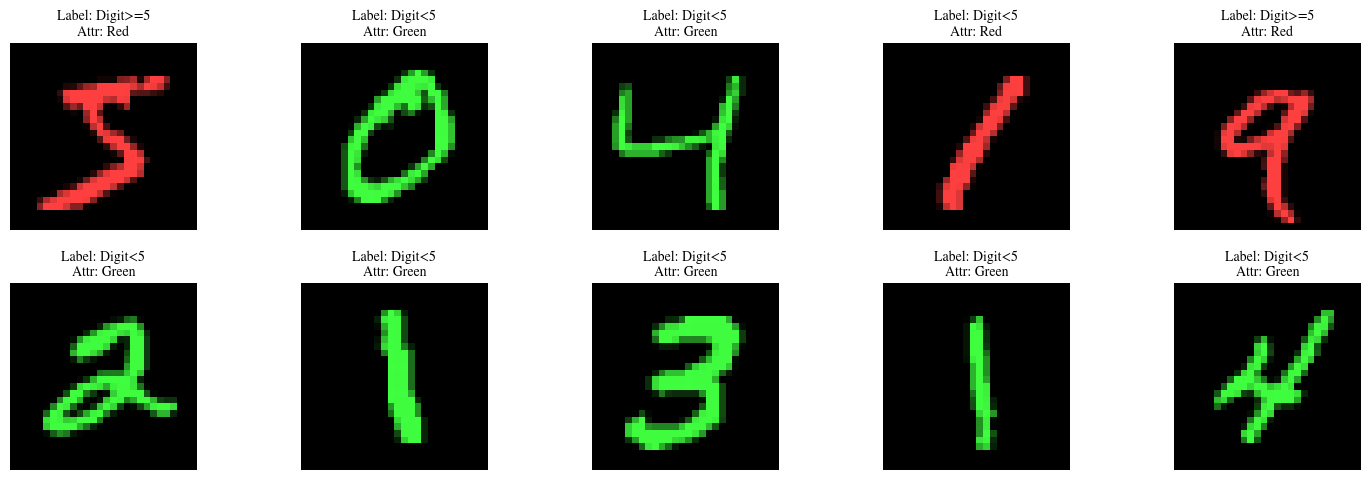


Applying L2 normalization to input data (||x||_2 = 1)...
Using 2000 samples for training and 2000 samples for testing.

Setting up MLP model and optimizer...

Applying manual parametrization for 'muP'...
   - Input Dim (d): 2352, Hidden Dim (n): 2048, Base LR (η): 0.1
   - Input Layer (W^1):       Init Var = 2.00, LR = 2.05e+02
   - Output Layer (W^L+1): Init Var = 1/4194304, LR = 4.88e-05

Starting training and evaluation loop...
Epoch    1/800 | Train [Loss: 0.6880, Worst: 0.7220, Acc: 0.5280, Worst: 0.0000] | Test [Loss: 0.6952, Worst: 0.7235, Acc: 0.4740, Worst: 0.0055]
Epoch    2/800 | Train [Loss: 0.6851, Worst: 0.7246, Acc: 0.5595, Worst: 0.0000] | Test [Loss: 0.6948, Worst: 0.7262, Acc: 0.4785, Worst: 0.0000]
Epoch    3/800 | Train [Loss: 0.6810, Worst: 0.7282, Acc: 0.6455, Worst: 0.0000] | Test [Loss: 0.6943, Worst: 0.7300, Acc: 0.4885, Worst: 0.0000]
Epoch    4/800 | Train [Loss: 0.6759, Worst: 0.7329, Acc: 0.7405, Worst: 0.0000] | Test [Loss: 0.6938, Worst: 0.7349, Acc: 0.5

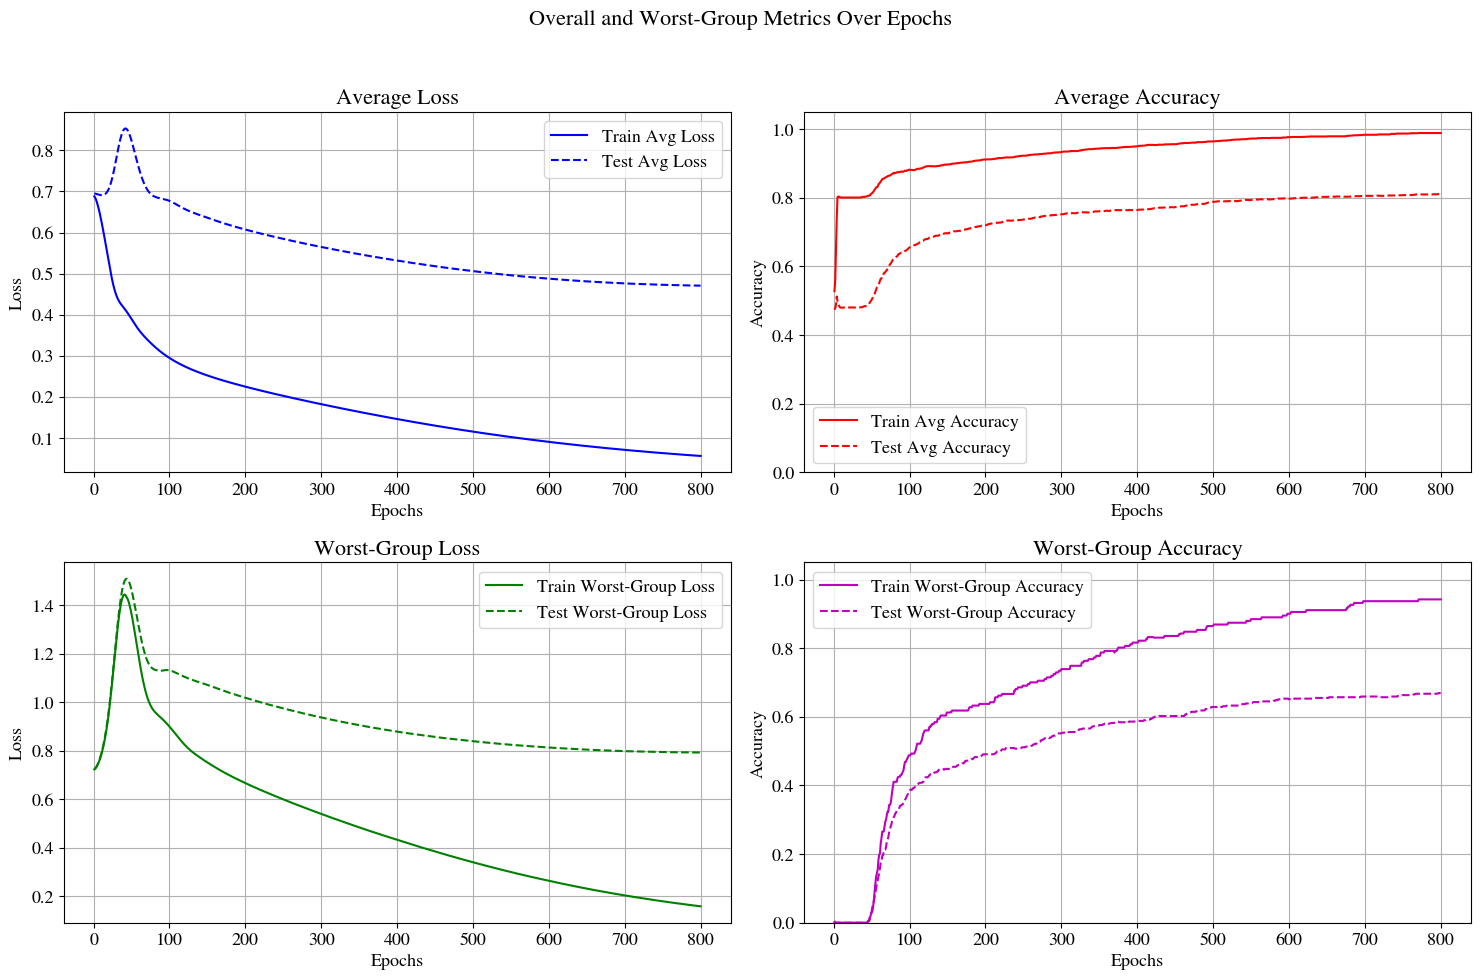

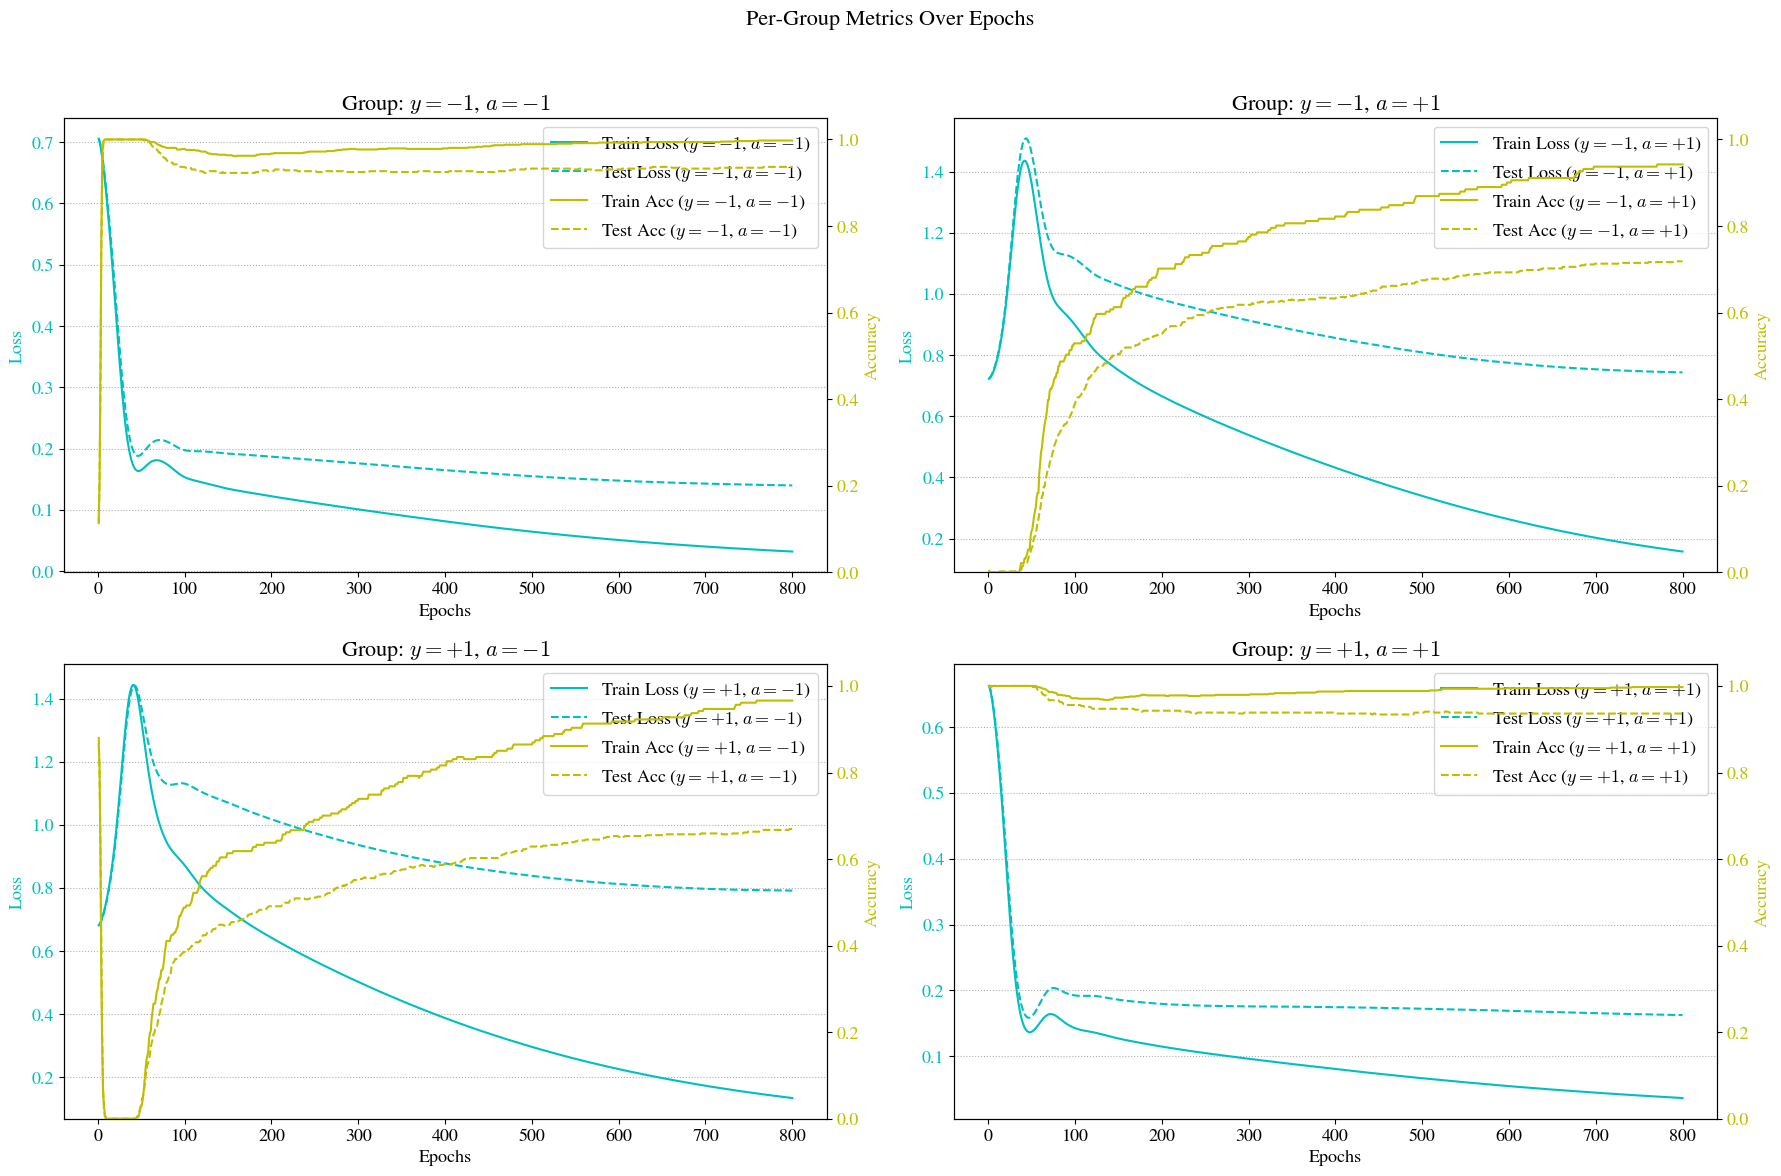


Plotting misclassification rates for each group on the test set...


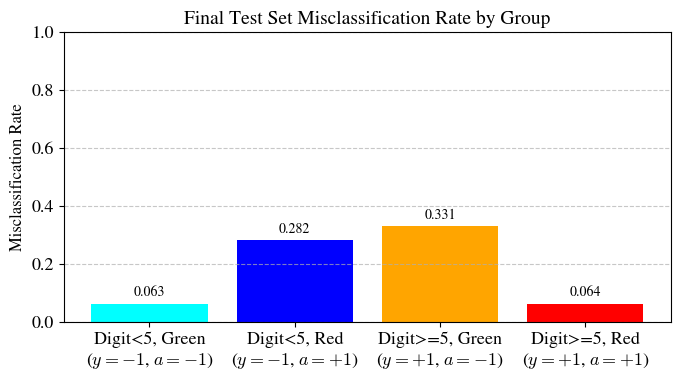


Plotting the evolution of Wasserstein distances over epochs (Train vs. Test)...


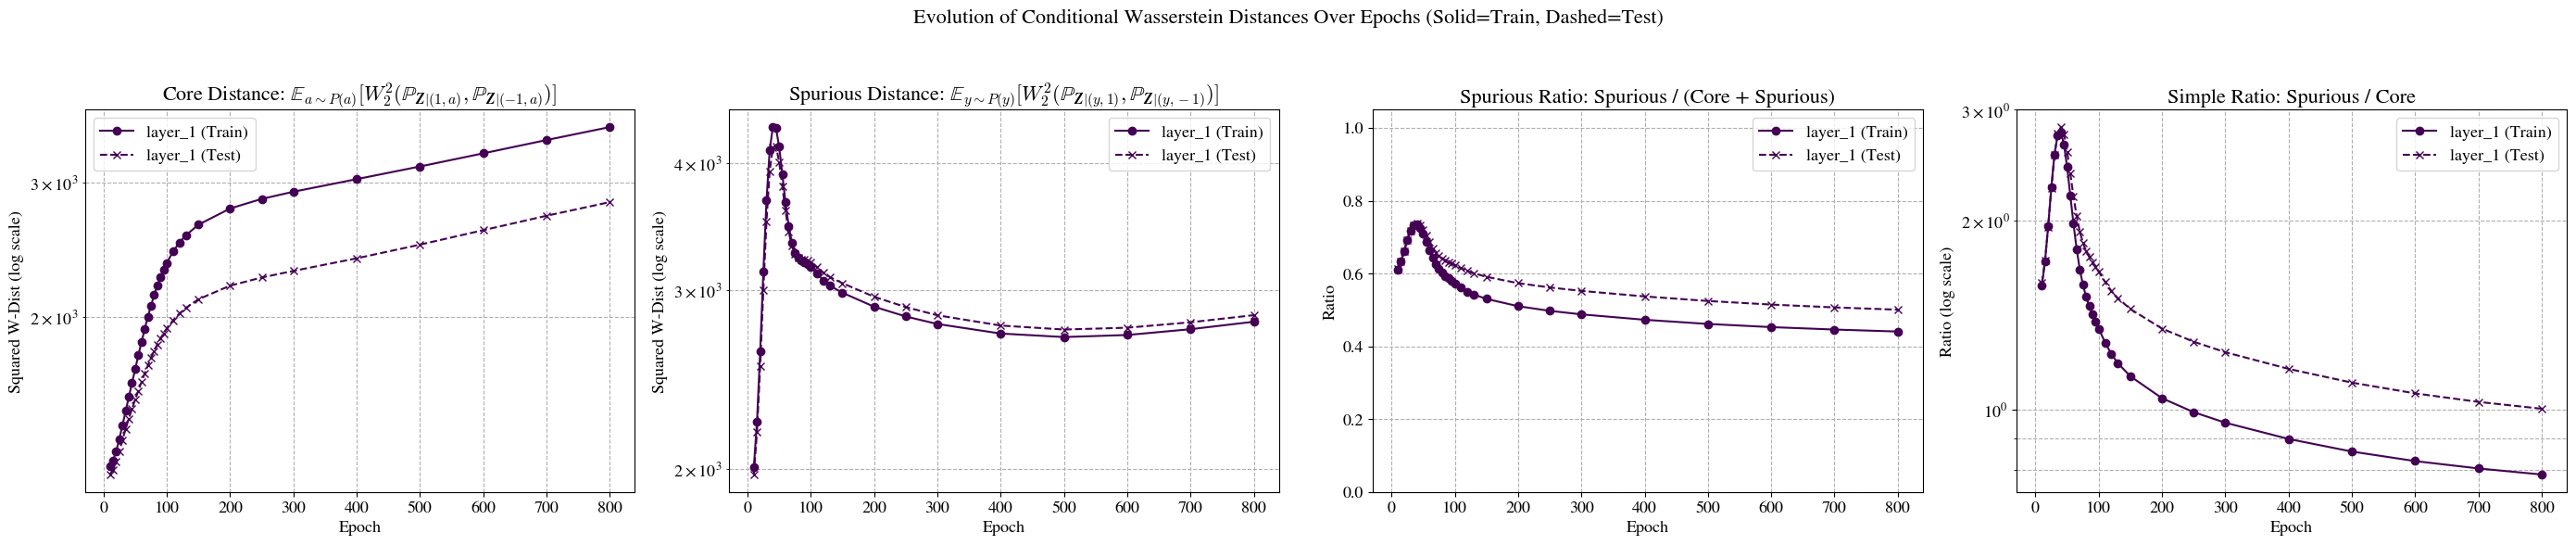

In [7]:
if __name__ == '__main__':
    # --- 実験設定 ---
    USE_SKIP_CONNECTIONS = False
    DATASET_NAME = 'ColoredMNIST' # WaterBirds, ColoredMNIST
    INITIALIZATION_METHOD = 'muP'
    NUM_TRAIN_SAMPLES = 2000
    NUM_TEST_SAMPLES = 2000
    NUM_HIDDEN_LAYERS = 1
    HIDDEN_DIM = 2048
    EPOCHS = 800
    BATCH_SIZE = 2000
    LEARNING_RATE = 0.1
    OPTIMIZER_TYPE = 'SGD'
    MOMENTUM = 0.9
    TRAIN_CORRELATION, TEST_CORRELATION = 0.6, 0.0
    N_NEIGHBORS_MI = 5
    SHOW_SAMPLES = True
    NUM_SAMPLES_TO_SHOW = 10
    DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

    # 相互情報量やWasserstein距離を計算するエポックを指定
    ANALYSIS_EPOCHS = [10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 110, 120, 130, 150, 200, 250, 300, 400, 500, 600, 700, EPOCHS]
    # t-SNE可視化を実行するエポックを個別に指定（空リスト[]にすれば実行されない）
    TSNE_VISUALIZATION_EPOCHS = [15, 100, EPOCHS]

    # --- 各種解析の有効/無効フラグ ---
    # 相互情報量の計算を実行するかどうか
    ANALYZE_MUTUAL_INFORMATION = False
    # t-SNE可視化を全体として有効にするか（個別のエポック指定は上記リストで行う）
    PERFORM_TSNE_VISUALIZATION = False
    # logitを情報量分析やt-SNEの対象に含めるか
    ANALYZE_LOGIT = False
    # 解析対象のデータセットを指定 ('train', 'test', 'both')
    #（t-SNEはこの設定に依らず常に train と test の両方を描画する）
    ANALYSIS_TARGET = 'both'

    print(f"Using device: {DEVICE}\nSelected Dataset: {DATASET_NAME}")
    print(f"Initialization: {INITIALIZATION_METHOD}")
    print(f"Skip Connections: {'ENABLED' if USE_SKIP_CONNECTIONS else 'DISABLED'}")
    print(f"Analysis will be performed on: '{ANALYSIS_TARGET}' dataset(s)")
    if ANALYZE_MUTUAL_INFORMATION:
        print(f"Mutual information analysis is ENABLED for epochs: {ANALYSIS_EPOCHS}.")
    else:
        print("Mutual information analysis is DISABLED.")
    if PERFORM_TSNE_VISUALIZATION:
        print(f"t-SNE visualization is ENABLED for epochs: {TSNE_VISUALIZATION_EPOCHS}.")
    else:
        print("t-SNE visualization is DISABLED.")
    if ANALYZE_LOGIT:
        print("Logit layer analysis is ENABLED.")
    else:
        print("Logit layer analysis is DISABLED.")

    # 解析対象レイヤーリストを定義
    all_target_layers = [f'layer_{i+1}' for i in range(NUM_HIDDEN_LAYERS)]
    if ANALYZE_LOGIT:
        all_target_layers.append('logit')
    print(f"Layers to be analyzed: {all_target_layers}")

    # --- データセットの準備 ---
    if DATASET_NAME == 'ColoredMNIST':
        IMAGE_SIZE = 28
        print("\nPreparing Colored MNIST dataset...")
        train_mnist = MNIST('./data', train=True, download=True)
        test_mnist = MNIST('./data', train=False, download=True)
        X_train_color, y_train_pm1, a_train_pm1 = colorize_mnist(train_mnist.data[:NUM_TRAIN_SAMPLES], train_mnist.targets[:NUM_TRAIN_SAMPLES], TRAIN_CORRELATION)
        X_test_color, y_test_pm1, a_test_pm1 = colorize_mnist(test_mnist.data[:NUM_TEST_SAMPLES], test_mnist.targets[:NUM_TEST_SAMPLES], TEST_CORRELATION)
    elif DATASET_NAME == 'WaterBirds':
        IMAGE_SIZE = 224
        print("\nPreparing WaterBirds dataset...")
        X_train_color, y_train_pm1, a_train_pm1, X_test_color, y_test_pm1, a_test_pm1 = \
            get_waterbirds_dataset(NUM_TRAIN_SAMPLES, NUM_TEST_SAMPLES, IMAGE_SIZE)
    else:
        raise ValueError("Unsupported DATASET_NAME.")

    if SHOW_SAMPLES:
        print("Showing original images before normalization...")
        show_dataset_samples(X_train_color, y_train_pm1, a_train_pm1, DATASET_NAME, NUM_SAMPLES_TO_SHOW)

    # 入力データをL2ノルムで正規化
    print("\nApplying L2 normalization to input data (||x||_2 = 1)...")
    X_train_color = l2_normalize_images(X_train_color)
    X_test_color = l2_normalize_images(X_test_color)

    print(f"Using {len(X_train_color)} samples for training and {len(X_test_color)} samples for testing.")
    train_loader = DataLoader(TensorDataset(X_train_color, y_train_pm1), batch_size=BATCH_SIZE, shuffle=True)

    if DATASET_NAME == 'WaterBirds':
        display_group_distribution(y_train_pm1, a_train_pm1, "Train Set")
        display_group_distribution(y_test_pm1, a_test_pm1, "Test Set")

    # --- モデルとオプティマイザ ---
    print(f"\nSetting up MLP model and optimizer...")
    input_dim = 3 * IMAGE_SIZE * IMAGE_SIZE

    model = MLP(input_dim, HIDDEN_DIM, NUM_HIDDEN_LAYERS, use_skip_connections=USE_SKIP_CONNECTIONS).to(DEVICE)

    optimizer_params = apply_manual_parametrization(
        model,
        method=INITIALIZATION_METHOD,
        base_lr=LEARNING_RATE,
        hidden_dim=HIDDEN_DIM,
        input_dim=input_dim
    )

    if OPTIMIZER_TYPE == 'Adam':
        optimizer = optim.Adam(optimizer_params)
    else:
        optimizer = optim.SGD(optimizer_params, momentum=MOMENTUM)

    # ==============================================================================
    # モデルの学習と評価ループ
    # ==============================================================================
    print("\nStarting training and evaluation loop...")

    history = {
        'train_avg_loss': [], 'test_avg_loss': [],
        'train_worst_loss': [], 'test_worst_loss': [],
        'train_avg_acc': [], 'test_avg_acc': [],
        'train_worst_acc': [], 'test_worst_acc': [],
        'train_group_losses': [], 'test_group_losses': [],
        'train_group_accs': [], 'test_group_accs': [],
    }

    mi_history_train, mi_history_test = {}, {}
    wd_history_train, wd_history_test = {}, {}

    for epoch in range(EPOCHS):
        model.train()
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(DEVICE), y_batch.to(DEVICE)
            optimizer.zero_grad()
            scores, _ = model(X_batch)
            loss = F.softplus(-y_batch * scores).mean()
            loss.backward()
            optimizer.step()

        # 評価と履歴の保存
        train_metrics = evaluate_model(model, X_train_color, y_train_pm1, a_train_pm1, DEVICE)
        test_metrics = evaluate_model(model, X_test_color, y_test_pm1, a_test_pm1, DEVICE)

        for key in ['avg_loss', 'worst_loss', 'avg_acc', 'worst_acc', 'group_losses', 'group_accs']:
            history[f'train_{key}'].append(train_metrics[key])
            history[f'test_{key}'].append(test_metrics[key])

        print(f"Epoch {epoch+1:4d}/{EPOCHS} | Train [Loss: {train_metrics['avg_loss']:.4f}, Worst: {train_metrics['worst_loss']:.4f}, Acc: {train_metrics['avg_acc']:.4f}, Worst: {train_metrics['worst_acc']:.4f}] | Test [Loss: {test_metrics['avg_loss']:.4f}, Worst: {test_metrics['worst_loss']:.4f}, Acc: {test_metrics['avg_acc']:.4f}, Worst: {test_metrics['worst_acc']:.4f}]")

        # --- チェックポイントでの特徴表現分析 ---
        current_epoch = epoch + 1
        is_analysis_epoch = current_epoch in ANALYSIS_EPOCHS
        is_tsne_epoch = PERFORM_TSNE_VISUALIZATION and (current_epoch in TSNE_VISUALIZATION_EPOCHS)

        # 何らかの分析・可視化が必要な場合のみ特徴量を抽出
        if is_analysis_epoch or is_tsne_epoch:
            print(f"\n{'='*30} CHECKPOINT ANALYSIS @ EPOCH {current_epoch} {'='*30}")
            model.eval()

            # --- 1. 特徴量抽出 ---
            all_train_outputs_dict, all_test_outputs_dict = {}, {}
            with torch.no_grad():
                train_loader_full = DataLoader(TensorDataset(X_train_color), batch_size=BATCH_SIZE)
                for i, (X_batch,) in enumerate(train_loader_full):
                    _, batch_outputs = model(X_batch.to(DEVICE))
                    for key, value in batch_outputs.items():
                        if i == 0: all_train_outputs_dict[key] = value.cpu()
                        else: all_train_outputs_dict[key] = torch.cat((all_train_outputs_dict[key], value.cpu()), dim=0)

                test_loader_full = DataLoader(TensorDataset(X_test_color), batch_size=BATCH_SIZE)
                for i, (X_batch,) in enumerate(test_loader_full):
                    _, batch_outputs = model(X_batch.to(DEVICE))
                    for key, value in batch_outputs.items():
                        if i == 0: all_test_outputs_dict[key] = value.cpu()
                        else: all_test_outputs_dict[key] = torch.cat((all_test_outputs_dict[key], value.cpu()), dim=0)

            # --- 2. 各種指標の分析 (ANALYSIS_EPOCHSに含まれる場合のみ) ---
            if is_analysis_epoch:
                mi_results_epoch_train, mi_results_epoch_test = {}, {}
                wd_results_epoch_train, wd_results_epoch_test = {}, {}

                for layer_name in all_target_layers:
                    # --- Train Data Analysis ---
                    if ANALYSIS_TARGET in ['train', 'both'] and layer_name in all_train_outputs_dict:
                        Z_train = all_train_outputs_dict[layer_name].numpy()
                        core_mi, sp_mi, mi_ratio, core_wd, sp_wd, wd_ratio, wd_simple_ratio = analyze_layer(
                            layer_name, Z_train, y_train_pm1.numpy(), a_train_pm1.numpy(), N_NEIGHBORS_MI, "Train",
                            analyze_mi=ANALYZE_MUTUAL_INFORMATION
                        )
                        if ANALYZE_MUTUAL_INFORMATION:
                            mi_results_epoch_train[layer_name] = (core_mi, sp_mi, mi_ratio)
                        if not np.isnan(core_wd):
                            wd_results_epoch_train[layer_name] = (core_wd, sp_wd, wd_ratio, wd_simple_ratio)

                    # --- Test Data Analysis ---
                    if ANALYSIS_TARGET in ['test', 'both'] and layer_name in all_test_outputs_dict:
                        Z_test = all_test_outputs_dict[layer_name].numpy()
                        core_mi, sp_mi, mi_ratio, core_wd, sp_wd, wd_ratio, wd_simple_ratio = analyze_layer(
                            layer_name, Z_test, y_test_pm1.numpy(), a_test_pm1.numpy(), N_NEIGHBORS_MI, "Test",
                            analyze_mi=ANALYZE_MUTUAL_INFORMATION
                        )
                        if ANALYZE_MUTUAL_INFORMATION:
                            mi_results_epoch_test[layer_name] = (core_mi, sp_mi, mi_ratio)
                        if not np.isnan(core_wd):
                            wd_results_epoch_test[layer_name] = (core_wd, sp_wd, wd_ratio, wd_simple_ratio)

                # --- 3. 分析結果の保存 ---
                if ANALYZE_MUTUAL_INFORMATION:
                    if mi_results_epoch_train: mi_history_train[current_epoch] = mi_results_epoch_train
                    if mi_results_epoch_test: mi_history_test[current_epoch] = mi_results_epoch_test

                if wd_results_epoch_train: wd_history_train[current_epoch] = wd_results_epoch_train
                if wd_results_epoch_test: wd_history_test[current_epoch] = wd_results_epoch_test

            # --- 4. t-SNE可視化 (TSNE_VISUALIZATION_EPOCHSに含まれる場合のみ) ---
            if is_tsne_epoch:
                visualize_tsne_layers(model, X_train_color, y_train_pm1, a_train_pm1,
                                      X_test_color, y_test_pm1, a_test_pm1,
                                      all_target_layers,
                                      BATCH_SIZE, DEVICE, epoch_num=current_epoch)

            print(f"{'='*30} END OF ANALYSIS @ EPOCH {current_epoch} {'='*30}\n")

    # ==============================================================================
    # 最終結果のプロット
    # ==============================================================================
    print("\nTraining finished. Plotting final results and analysis.")

    # --- 学習履歴のグラフを描画 ---
    plot_training_history(history)

    # --- 最終的な誤分類率をプロット ---
    final_test_metrics = {'group_accs': history['test_group_accs'][-1]}
    plot_misclassification_rates(final_test_metrics)

    # --- 相互情報量の時系列変化をプロット ---
    if ANALYZE_MUTUAL_INFORMATION:
        plot_mi_evolution(mi_history_train, mi_history_test, all_target_layers)

    # --- Wasserstein距離の時系列変化をプロット ---
    plot_wd_evolution(wd_history_train, wd_history_test, all_target_layers)